# Testing notebook for nifty fit on atmosphere TODs directly (no image)

# Try to add a nifty model for sampling the input map

numpy version: 2.1.1


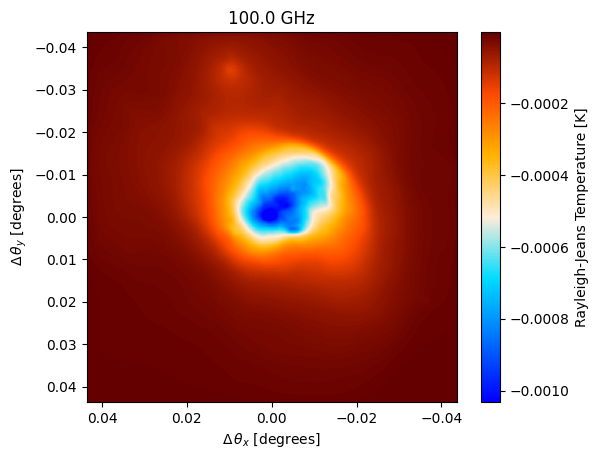

In [1]:
import numpy as np
print(f"numpy version: {np.__version__}")
import matplotlib.pyplot as plt
import maria
import sys
import os

# Relative import of sample_maps for now
sys.path.append(os.path.abspath('../python'))
import mapsampling_jax
from mapsampling_jax import sample_maps

map_filename = maria.io.fetch("maps/cluster.fits")

# load in the map from a fits file
input_map = maria.map.read_fits(filename=map_filename, #filename
                                resolution=-8.714e-05, #pixel size in degrees
                                index=0, #index for fits file
                                center=(150, 10), # position in the sky
                                units='Jy/pixel' # Units of the input map 
                               )

input_map.to(units="K_RJ").plot()

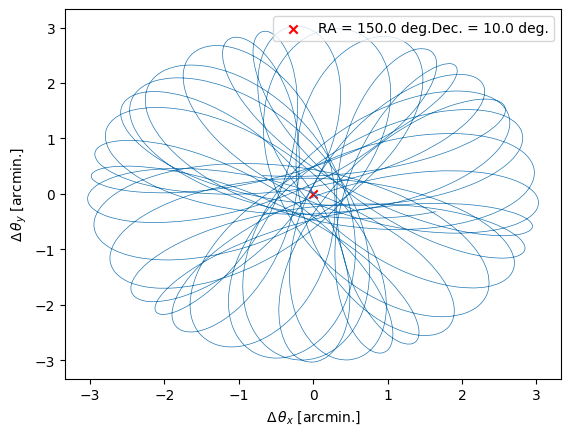

In [2]:
#load the map into maria
plan = maria.get_plan(scan_pattern="daisy", # scanning pattern
                      scan_options={"radius": 0.05, "speed": 0.01}, # in degrees
                      duration=600, # integration time in seconds
                      # duration=300, # integration time in seconds
                      sample_rate=50, # in Hz
                      scan_center=(150, 10), # position in the sky
                      frame="ra_dec")

plan.plot()

2024-10-08 13:25:07.689 INFO: Constructed instrument.
2024-10-08 13:25:07.690 INFO: Constructed plan.
2024-10-08 13:25:07.690 INFO: Constructed site.
2024-10-08 13:25:08.290 INFO: Constructed boresight.
2024-10-08 13:25:08.700 INFO: Constructed offsets.


Initialized base in 1011 ms.


Generating noise: 100%|██████████| 1/1 [00:00<00:00,  2.25it/s]
Generating atmosphere: 4it [00:01,  3.65it/s]
Sampling map (m2/f093): 100%|██████████| 1/1 [00:04<00:00,  4.73s/it]


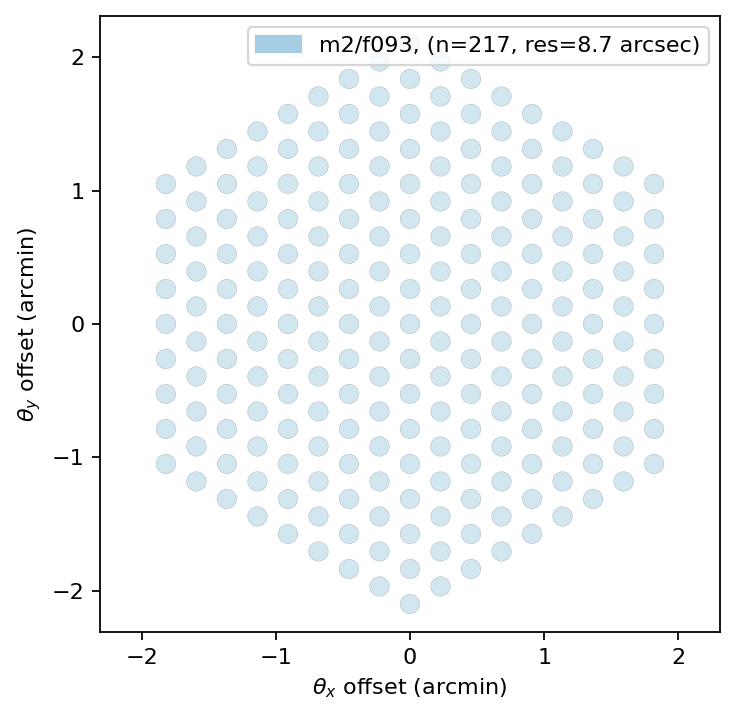

In [3]:
# instrument = maria.get_instrument('MUSTANG-2')
instrument = mapsampling_jax.instrument
instrument.plot()

sim_truthmap = maria.Simulation(instrument, 
                                plan=plan,
                                site="llano_de_chajnantor", 
                                map=input_map,
                                # noise=False,
                                atmosphere="2d",
                                # cmb="generate",
                                )

tod_truthmap = sim_truthmap.run()

In [4]:
dx, dy = sim_truthmap.coords.offsets(frame=sim_truthmap.map.frame, center=sim_truthmap.map.center)
dx = dx.compute()
dy = dy.compute()

dx

array([[-1.95983289e-04, -1.93241722e-04, -1.89834280e-04, ...,
         4.73739401e-04,  4.76682915e-04,  4.80085936e-04],
       [-2.45111164e-04, -2.42369809e-04, -2.38962642e-04, ...,
         4.28384607e-04,  4.31327861e-04,  4.34730605e-04],
       [-1.20794450e-04, -1.18052925e-04, -1.14645544e-04, ...,
         5.49616894e-04,  5.52560370e-04,  5.55963347e-04],
       ...,
       [ 1.21850892e-04,  1.24594200e-04,  1.28003905e-04, ...,
         7.60700211e-04,  7.63645840e-04,  7.67051118e-04],
       [-4.04470989e-04, -4.01727385e-04, -3.98317250e-04, ...,
         2.29557762e-04,  2.32503650e-04,  2.35909239e-04],
       [-7.45372078e-04, -7.42630682e-04, -7.39223420e-04, ...,
        -7.22351429e-05, -6.92919267e-05, -6.58891924e-05]])

Running mapper (m2/f093): 100%|██████████| 1/1 [00:05<00:00,  5.47s/it]


mapdata_truth shape: (1, 1000, 1000)
mapdata_truth mean: -8.726028151723567e-05


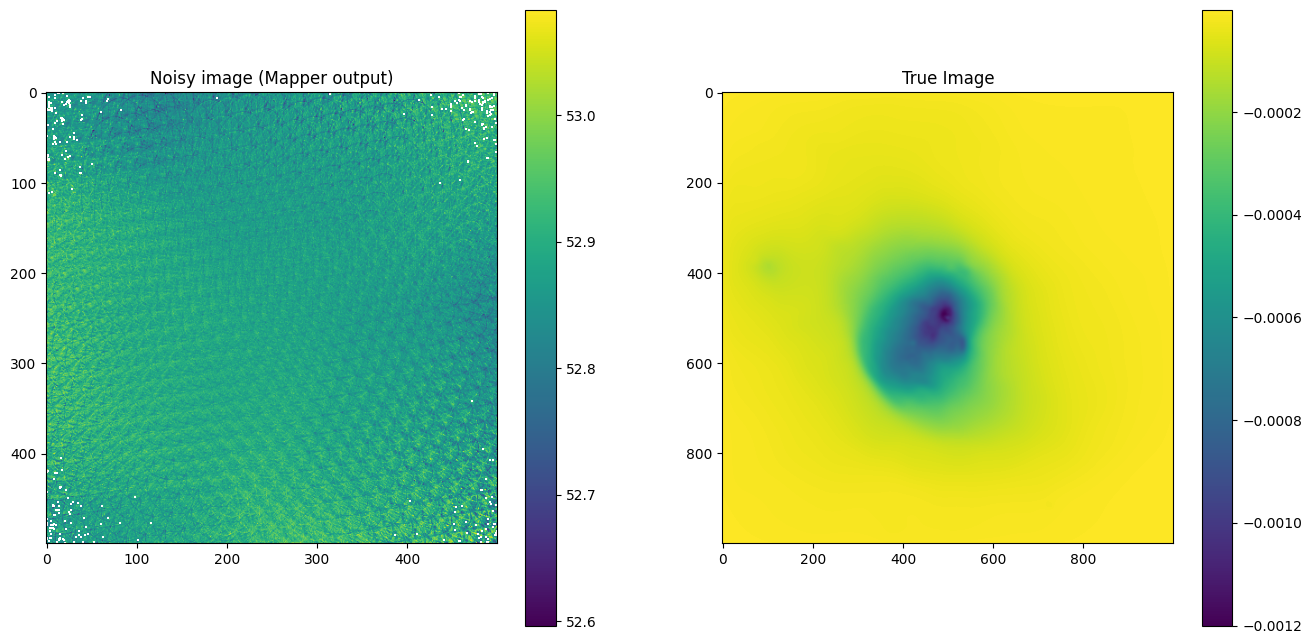

In [5]:
from maria.map.mappers import BinMapper

# Run mapper without any filtering to get noisy mimge
mapper_truthmap = BinMapper(center=(150, 10), frame="ra_dec", width=0.1, height=0.1, resolution=2e-4, map_postprocessing={"gaussian_filter": {"sigma": 0}} )
mapper_truthmap.add_tods(tod_truthmap)
output_truthmap = mapper_truthmap.run()

mapdata_truth = np.float64(sim_truthmap.map.data)
mapdata_truth = np.nan_to_num(mapdata_truth, nan=np.nanmean(mapdata_truth)) # replace nan value by img mean

print("mapdata_truth shape:", mapdata_truth.shape)
print("mapdata_truth mean:", mapdata_truth.mean())

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(output_truthmap.data[0].T)
fig.colorbar(im0)
axes[0].title.set_text("Noisy image (Mapper output)")

im1 = axes[1].imshow(mapdata_truth[0])
fig.colorbar(im1)
axes[1].title.set_text("True Image")

plt.show()

# Re-implement map sampling in JAX for nifty response function:

In [6]:
os.environ['CUDA_VISIBLE_DEVICES'] = '2'

import jax
from jax import random
import jax.numpy as jnp

import nifty8.re as jft
import matplotlib.pyplot as plt

import numpy as np

from functools import reduce
from operator import or_

seed = 42
key = random.PRNGKey(seed)

2024-10-08 13:25:34.418 INFO: Unable to initialize backend 'rocm': module 'jaxlib.xla_extension' has no attribute 'GpuAllocatorConfig'
2024-10-08 13:25:34.420 INFO: Unable to initialize backend 'tpu': INTERNAL: Failed to open libtpu.so: libtpu.so: cannot open shared object file: No such file or directory


# Test TOD agreement:

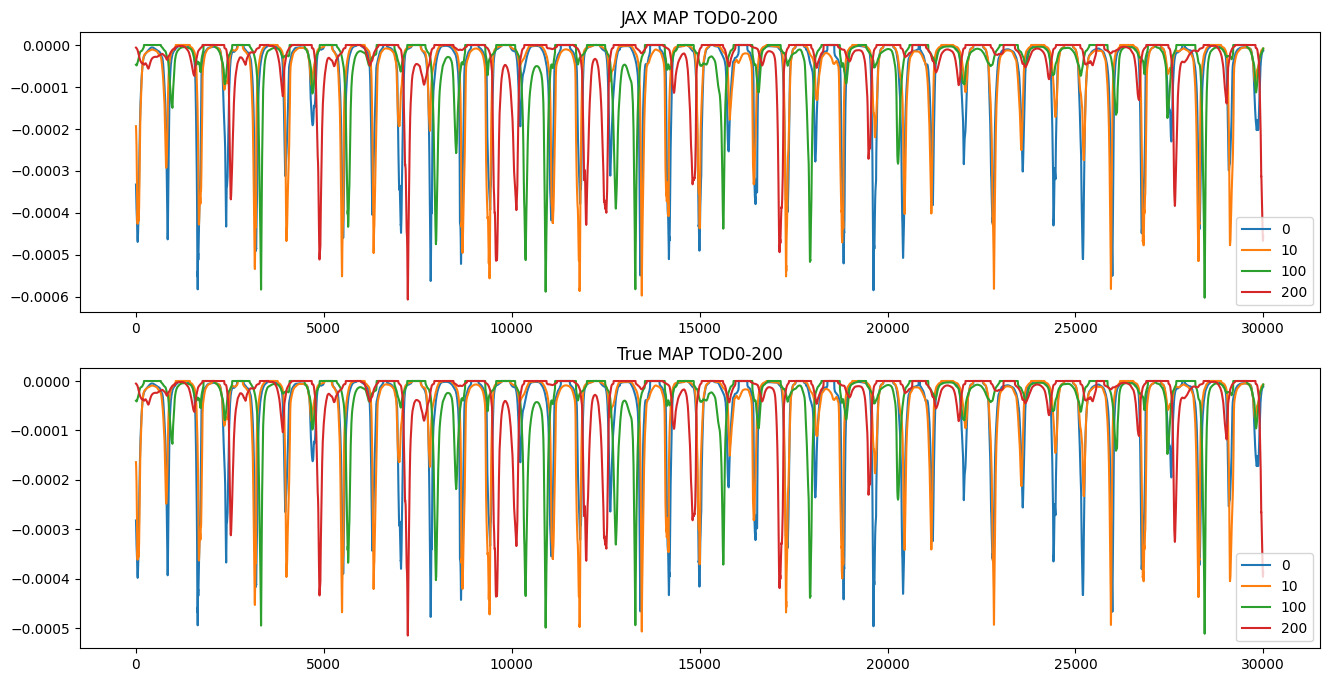

In [7]:
jax_tods_map = sample_maps(mapdata_truth, dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

fig, axes = plt.subplots(2, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods_map[i], label=i)

    tods_map = np.float64(tod_truthmap.components['map'].compute())
    im1 = axes[1].plot(tods_map[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'True MAP TOD0-{i}')
axes[1].legend()

plt.show()

# Smooth atmosphere TODs:

In [8]:
import scipy as sp

jax_tods_atmos = tod_truthmap.components['atmosphere']
jax_tods_atmos_smooth = np.zeros(jax_tods_atmos.shape)

for i in range(jax_tods_atmos.shape[0]):
    jax_tods_atmos_smooth[i] = sp.ndimage.gaussian_filter1d(jax_tods_atmos[i], sigma=2e2)

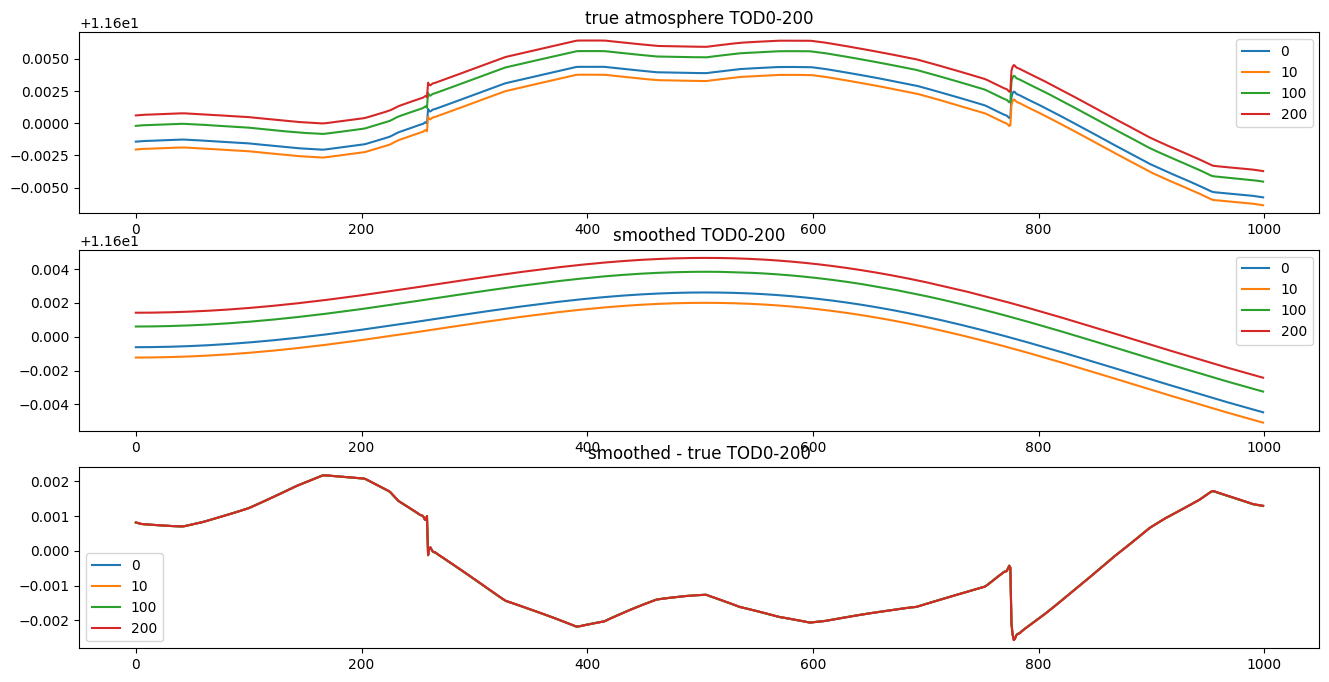

In [9]:
# plot smoothed atmos:

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

for i in [0, 10, 100, 200]:
    im0 = axes[0].plot(jax_tods_atmos[i, 0:1000], label=i)
    im1 = axes[1].plot(jax_tods_atmos_smooth[i, 0:1000], label=i)
    im2 = axes[2].plot(jax_tods_atmos_smooth[i, 0:1000] - jax_tods_atmos[i, 0:1000], label=i)
    
axes[0].title.set_text(f'true atmosphere TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'smoothed TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'smoothed - true TOD0-{i}')
axes[2].legend()

plt.show()

# Prepare noised input TODs:

Noise stddev: 0.00025134266


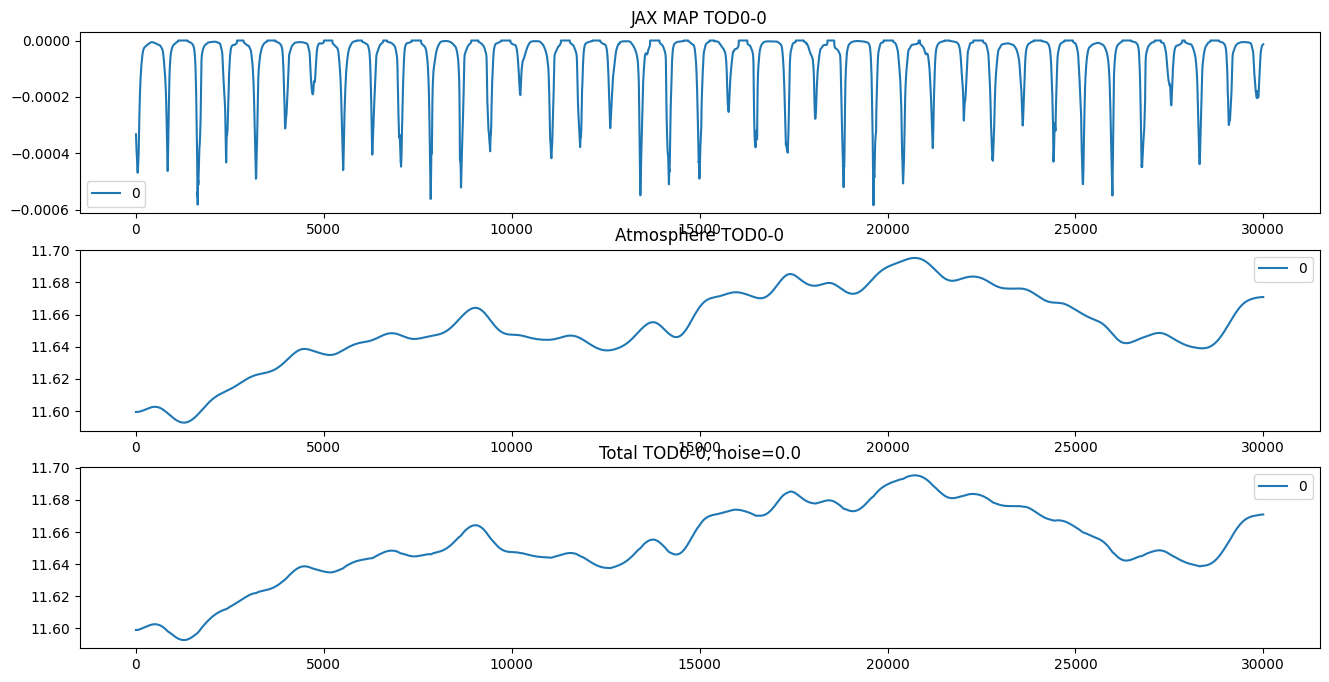

In [30]:
# Pick noise level for rest of run:
noiselevel = 0.0
# noiselevel = 0.1
# noiselevel = 0.5
# noiselevel = 1.0

# Add n TODs for atmos:
n = 1
# n = noised_jax_tod.shape[0]

jax_tods_atmos = tod_truthmap.components['atmosphere']
# noised_jax_tod = np.float64(jax_tods_map) + np.float64(jax_tods_atmos) + np.float64(tod_truthmap.components['noise']*noiselevel)

noised_jax_tod = np.float64(jax_tods_map) + np.float64(tod_truthmap.components['noise']*noiselevel)
noised_jax_tod[:n] += np.float64(jax_tods_atmos_smooth[:n]) 
# noised_jax_tod[:n] = np.float64(jax_tods_atmos_smooth[:n])

print("Noise stddev:", np.std(tod_truthmap.components['noise'].compute()))

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

# for i in [0, 10, 100, 200]:
for i in [0]:
    im0 = axes[0].plot(jax_tods_map[i], label=i)
    # im1 = axes[1].plot(jax_tods_atmos[i], label=i)
    im1 = axes[1].plot(jax_tods_atmos_smooth[i], label=i)
    im2 = axes[2].plot(noised_jax_tod[i], label=i)
    
axes[0].title.set_text(f'JAX MAP TOD0-{i}')
axes[0].legend()
axes[1].title.set_text(f'Atmosphere TOD0-{i}')
axes[1].legend()
axes[2].title.set_text(f'Total TOD0-{i}, noise={noiselevel}')
axes[2].legend()

plt.show()

# Next, initialise nifty prior model

Start with the atmosphere TOD model:

In [31]:
dims_atmos = (jax_tods_atmos.shape[1] + 2000,)
padding_atmos = dims_atmos[0] - jax_tods_atmos.shape[1]

# correlated field zero mode GP offset and stddev
# cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.001, 0.1))
cf_zm_tod = dict(offset_mean=jax_tods_atmos.mean().compute(), offset_std=(0.0005, 0.001))

# correlated field fluctuations (mostly don't need tuning)
# fluctuations: y-offset in power spectrum in fourier space (zero mode)
# loglogavgslope: power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
# flexibility=(1.5e0, 5e-1), # deviation from simple power-law
# asperity=(5e-1, 5e-2), # small scale features in power-law
cf_fl_tod = dict(
    fluctuations=(0.005, 0.005), 
    loglogavgslope=(-3, 0.5), 
    flexibility=None,
    asperity=None,
)

# put together in correlated field model
cfm_tod = jft.CorrelatedFieldMaker("")
cfm_tod.set_amplitude_total_offset(**cf_zm_tod)
cfm_tod.add_fluctuations(
    dims_atmos, distances=1.0 / dims_atmos[0], **cf_fl_tod, prefix="tod ", non_parametric_kind="power"
)
# gp_tod = cfm_tod.finalize()

## Add one Correlated field per TOD with shared flucts and zero-mean

In [32]:
# init params for each TOD:

gps_tods = []
for i in range(n):
    cfmi = jft.CorrelatedFieldMaker(f'tod{i} ')
    # cfmi.set_amplitude_total_offset(**cf_zm_tod)
    cfmi._azm = cfm_tod._azm
    cfmi._offset_mean = cfm_tod._offset_mean
    cfmi._parameter_tree['zeromode'] = jft.ShapeWithDtype(())

    cfmi._fluctuations.append(cfm_tod._fluctuations[0])
    cfmi._target_grids.append(cfm_tod._target_grids[0])
    cfmi._parameter_tree.update(cfm_tod._fluctuations[0].domain)
    gps_tods.append(cfmi.finalize())

## Now for the map model:

In [33]:
dims_map = (1000, 1000)

# Map model

# correlated field zero mode GP offset and stddev
# cf_zm_map = dict(offset_mean=mapdata_truth.mean(), offset_std=(1e-7, 1e-6))
cf_zm_map = dict(offset_mean=mapdata_truth.mean(), offset_std=(1e-8, 1e-7))
# correlated field fluctuations (mostly don't need tuning)
cf_fl_map = dict(
    fluctuations=(1e-6, 1e-6), # fluctuations: y-offset in power spectrum in fourier space (zero mode)
    loglogavgslope=(-2.5e0, 5e-1), # power-spectrum slope in log-log space in frequency domain (Fourier space) Jakob: -4 -- -2
    flexibility=None,
    asperity=None,
    # flexibility=(1.5e0, 5e-1), # deviation from simple power-law
    # asperity=(5e-1, 5e-2), # small scale features in power-law
)

# put together in correlated field model
cfm_map = jft.CorrelatedFieldMaker("cfmap")
cfm_map.set_amplitude_total_offset(**cf_zm_map)
cfm_map.add_fluctuations(
    dims_map, distances=1.0 / dims_map[0], **cf_fl_map, prefix="ax1", non_parametric_kind="power"
)
gp_map = cfm_map.finalize()

In [34]:
# only tod:
# class Signal_TOD(jft.Model):
#     def __init__(self, gps_tods):
#         # self.gp_tod = gp_tod
#         # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
#         self.gps_tods = gps_tods
#         self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         # self.gp_map = gp_map
#         # super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
#         super().__init__(init=reduce(or_, [gp.init for gp in gps_tods]), domain=reduce(or_, [gp.domain for gp in gps_tods]))
    
#     def __call__(self, x):
#         res_tods = jnp.zeros(self.tgt)
#         for i, gp in enumerate(self.gps_tods):
#             res_tods = res_tods.at[i].set(gp(x))
        
#         return res_tods[:, padding_atmos//2:-padding_atmos//2]

#         # res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

#         # # Only add first n atmosphere tods, otherwise use map
#         # modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

#         # return modified_res_map

# signal_response_tod = Signal_TOD(gps_tods)

# # map only:
# class Signal_TOD(jft.Model):
#     def __init__(self, gp_map):
#         # self.gp_tod = gp_tod
#         # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
#         # self.gps_tods = gps_tods
#         # self.tgt = (len(gps_tods), gps_tods[0].target.size)
#         self.gp_map = gp_map
#         # super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
#         super().__init__(init=gp_map.init, domain=gp_map.domain)
    
#     def __call__(self, x):
#         # res_tods = jnp.zeros(self.tgt)
#         # for i, gp in enumerate(self.gps_tods):
#         #     res_tods = res_tods.at[i].set(gp(x))
        
#         res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)
#         return res_map

#         # Only add first n atmosphere tods, otherwise use map
#         # modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

#         # return modified_res_map
#         # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map
#         # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map[:n]
  
# signal_response_tod = Signal_TOD(gp_map)

In [35]:
# Define simple signal model with added map sampling
class Signal_TOD(jft.Model):
    def __init__(self, gps_tods, gp_map):
        # self.gp_tod = gp_tod
        # super().__init__(init=self.gp_tod.init, domain=jft.Vector(gp_tod.domain))
        self.gps_tods = gps_tods
        self.tgt = (len(gps_tods), gps_tods[0].target.size)
        self.gp_map = gp_map
        super().__init__(init=reduce(or_, [gp.init for gp in gps_tods] + [gp_map.init]), domain=reduce(or_, [gp.domain for gp in gps_tods] + [gp_map.domain]))
    
    def __call__(self, x):
        res_tods = jnp.zeros(self.tgt)
        for i, gp in enumerate(self.gps_tods):
            res_tods = res_tods.at[i].set(gp(x))
        
        res_map = sample_maps(jax.numpy.broadcast_to(self.gp_map(x), (1, dims_map[0], dims_map[1])), dx, dy, sim_truthmap.map.resolution, sim_truthmap.map.x_side, sim_truthmap.map.y_side)

        # Only add first n atmosphere tods, otherwise use map
        modified_res_map = res_map.at[:n, :].add(res_tods[:, padding_atmos//2:-padding_atmos//2])

        return modified_res_map
        # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map
        # return res_tods[:, padding_atmos//2:-padding_atmos//2] + res_map[:n]

signal_response_tod = Signal_TOD(gps_tods, gp_map)

# Define noise covariance
# if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x
if noiselevel == 0.0: noise_cov_inv_tod = lambda x: 1e-8**-2 * x
elif noiselevel == 0.1: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 0.5: noise_cov_inv_tod = lambda x: 1e-4**-2 * x
elif noiselevel == 1.0: noise_cov_inv_tod = lambda x: 2.5e-4**-2 * x

# Combine in likelihood - only fit 0th TOD for now!
# truth = noised_jax_tod[:n]
truth = noised_jax_tod
lh_tod = jft.Gaussian( truth, noise_cov_inv_tod).amend(signal_response_tod)

# lh = lh_tod + lh_map
# lh = lh_map
lh = lh_tod

# lh_map_grad = jax.grad(lh_map)
lh_tod_grad = jax.grad(lh_tod)

assuming a diagonal covariance matrix;
setting `std_inv` to `cov_inv(ones_like(data))**0.5`


In [36]:
signal_response_tod

Signal_TOD(
	<bound method Signal_TOD.__call__>,
	domain={'cfmapax1fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfmapax1loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'cfmapxi': ShapeWithDtype(shape=(1000, 1000), dtype=<class 'jax.numpy.float64'>),
	 'cfmapzeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'tod fluctuations': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'tod loglogavgslope': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>),
	 'tod0 xi': ShapeWithDtype(shape=(32000,), dtype=<class 'jax.numpy.float64'>),
	 'zeromode': ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)},
	init=Initializer(
		{'cfmapax1fluctuations': functools.partial(<function random_like at 0x7f32a1681580>, primals=ShapeWithDtype(shape=(), dtype=<class 'jax.numpy.float64'>)),
		 'cfmapax1loglogavgslope': functools.partial(<function random_like at 0x7f32a1681580>, primals=ShapeWi

# Draw Prior sample

(217, 30000)


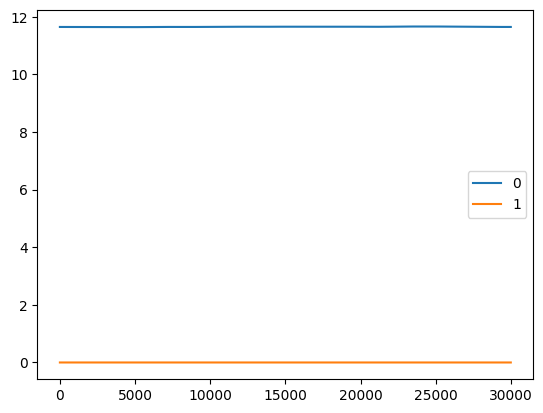

In [39]:
key, sub = jax.random.split(key)
xi = jft.random_like(sub, signal_response_tod.domain)
res = signal_response_tod(xi)
print(res.shape)

# for i in range(res.shape[0]):
for i in [0, 1]:
    plt.plot(np.arange(0, res.shape[1]), res[i], label=i)
plt.legend()
plt.show()

# MAP fit

In [40]:
n_it = 1
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
if noiselevel == 0.0: delta = 1e-4
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4

n_samples = 0 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60 # map
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=20 # map
        )
    ),
    sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
)

OPTIMIZE_KL: Starting 0001


M: →:0.5 ↺:False #∇²:06 |↘|:6.497036e+01 ➽:1.032006e+02
M: Iteration 1 ⛰:+1.112370e+16 Δ⛰:6.086588e+16
OPTIMIZE_KL: Iteration 0001 ⛰:+1.1124e+16
OPTIMIZE_KL: #(KL minimization steps) 1
OPTIMIZE_KL: Likelihood residual(s):
'reduced χ²: 3.4e+09±     0.0, avg: -1.6e+03±     0.0, #dof:6510000'

OPTIMIZE_KL: Prior residual(s):
cfmapax1fluctuations    :: 'reduced χ²:    0.13±     0.0, avg:    +0.37±     0.0, #dof:      1'
cfmapax1loglogavgslope  :: 'reduced χ²:   0.018±     0.0, avg:    +0.13±     0.0, #dof:      1'
cfmapxi                 :: 'reduced χ²:     1.0±     0.0, avg:  +0.0015±     0.0, #dof:1000000'
cfmapzeromode           :: 'reduced χ²:    0.58±     0.0, avg:    +0.76±     0.0, #dof:      1'
tod fluctuations        :: 'reduced χ²:    0.26±     0.0, avg:    +0.51±     0.0, #dof:      1'
tod loglogavgslope      :: 'reduced χ²:     1.9±     0.0, avg:     -1.4±     0.0, #dof:      1'
tod0 xi                 :: 'reduced χ²:     1.0±     0.0, avg:  -0.0072±     0.0, #dof:  32000'
zero

In [41]:
samples.pos

Vector(
	{'cfmapax1fluctuations': Array(0.36607392, dtype=float64),
	 'cfmapax1loglogavgslope': Array(0.13323612, dtype=float64),
	 'cfmapxi': Array([[-1.43169587,  0.6732484 ,  1.04357344, ..., -1.7575604 ,
	         2.73941836,  0.09480544],
	       [-0.98782462,  1.10532994, -0.16916742, ...,  0.47928954,
	         0.73661707,  0.92630188],
	       [ 0.93541218, -0.85313183,  1.14480039, ..., -1.6062401 ,
	         0.53563138,  0.34972859],
	       ...,
	       [-0.92844538,  0.32683885, -1.29948995, ...,  0.16847581,
	         1.20173677, -0.23871182],
	       [ 2.51316611, -0.36521839, -0.17171371, ...,  0.8178574 ,
	         0.08223633,  1.00081474],
	       [ 0.28105736, -0.49739871,  0.23260697, ..., -0.65579102,
	        -0.53569933,  1.57395598]], dtype=float64),
	 'cfmapzeromode': Array(0.75857864, dtype=float64),
	 'tod fluctuations': Array(0.50982515, dtype=float64),
	 'tod loglogavgslope': Array(-1.36053239, dtype=float64),
	 'tod0 xi': Array([ 0.63127669,  0.07213755, -3

In [42]:
def printfitresults():
    print("Fit Results (res, init, std)")

    print("\nTODs:")
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_tod['fluctuations'])(samples.pos['tod fluctuations'])}, {cf_fl_tod['fluctuations'][0]}, {cf_fl_tod['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_tod['loglogavgslope'])(samples.pos['tod loglogavgslope'])}, {cf_fl_tod['loglogavgslope'][0]}, {cf_fl_tod['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_tod['offset_std'])(samples.pos['zeromode'])}, {cf_zm_tod['offset_std'][0]}, {cf_zm_tod['offset_std'][1]}")

    # If custom zeromode per TOD:
    # for i in range(n):
    #     test = samples.pos[f"tod{i} zeromode"]
    #     print(f"tod{i} zeromode: {jft.LogNormalPrior(cf_zm_tod['offset_mean'], cf_zm_tod['offset_std'][0])(test)}, {cf_zm_tod['offset_mean']}, {cf_zm_tod['offset_std'][0]}")
    
    print("map:")
    print(f"\tfluctuations: {jft.LogNormalPrior(*cf_fl_map['fluctuations'])(samples.pos['cfmapax1fluctuations'])}, {cf_fl_map['fluctuations'][0]}, {cf_fl_map['fluctuations'][1]}")
    print(f"\tloglogvarslope: {jft.NormalPrior(*cf_fl_map['loglogavgslope'])(samples.pos['cfmapax1loglogavgslope'])}, {cf_fl_map['loglogavgslope'][0]}, {cf_fl_map['loglogavgslope'][1]}")
    print(f"\tzeromode std (LogNormal): {jft.LogNormalPrior(*cf_zm_map['offset_std'])(samples.pos['cfmapzeromode'])}, {cf_zm_map['offset_std'][0]}, {cf_zm_map['offset_std'][1]}")
    
    
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.005404984587580132, 0.005, 0.005
	loglogvarslope: -3.680266195241775, -3, 0.5
	zeromode std (LogNormal): 8.632622291650384e-06, 0.0005, 0.001
map:
	fluctuations: 9.590643924831009e-07, 1e-06, 1e-06
	loglogvarslope: -2.43338194043275, -2.5, 0.5
	zeromode std (LogNormal): 5.0767259667823085e-09, 1e-08, 1e-07


(217, 30000)


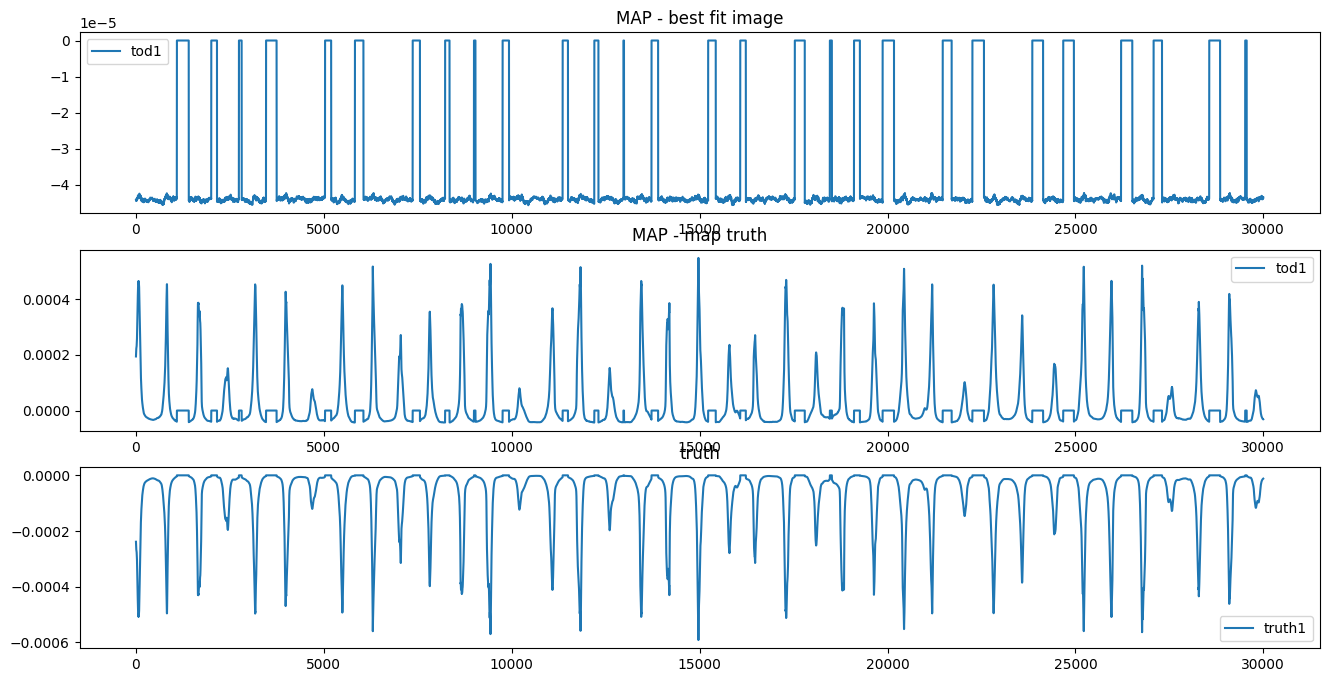

In [47]:
res = signal_response_tod(samples.pos)
print(res.shape)

fig, axes = plt.subplots(3, 1, figsize=(16, 8))

# for i in range(0, res.shape[0], res.shape[0]//10):
for i in [1]:
    im0 = axes[0].plot(np.arange(0, res.shape[1]), res[i], label=f"tod{i}")
    im1 = axes[1].plot(np.arange(0, res.shape[1]), res[i] - truth[i], label=f"tod{i}")
    im2 = axes[2].plot(truth[i], label=f"truth{i}")

axes[0].title.set_text('MAP - best fit image')
axes[0].legend()
axes[1].title.set_text('MAP - map truth')
axes[1].legend()
axes[2].title.set_text('truth')
axes[2].legend()

plt.show()

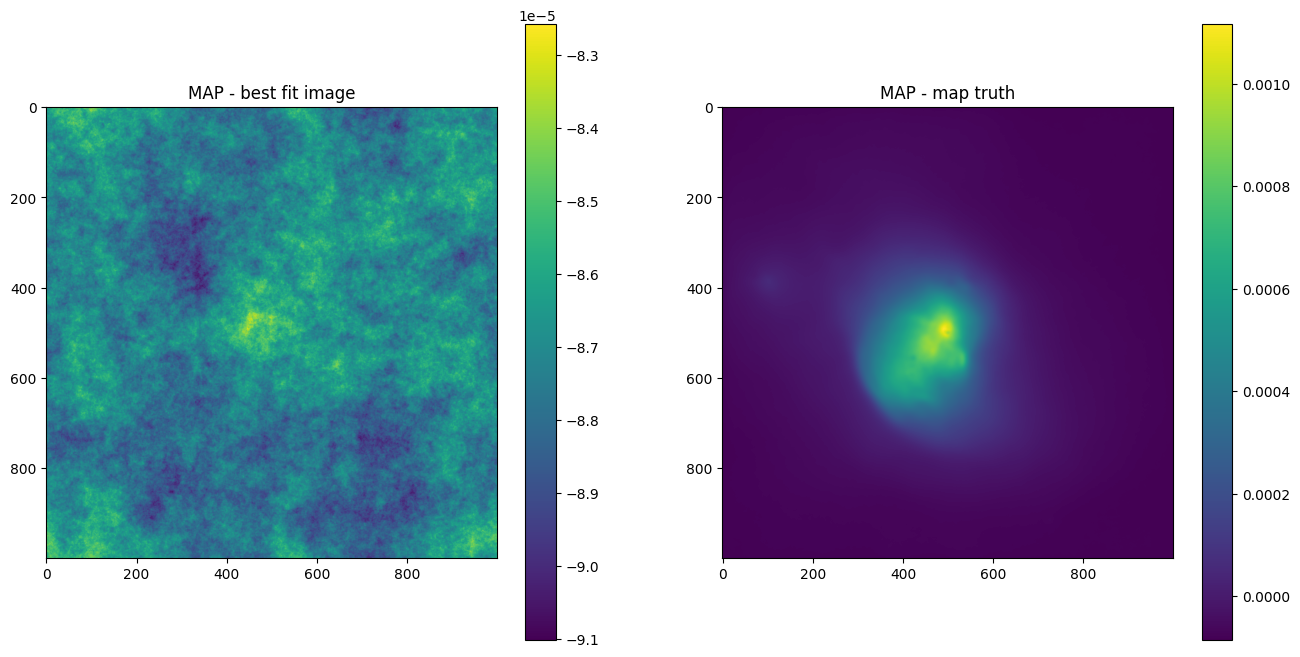

In [48]:
# plot maximum of posterior (mode)
sig_map = gp_map(samples.pos) # when splitting up in different field models

fig, axes = plt.subplots(1, 2, figsize=(16, 8))

im0 = axes[0].imshow(sig_map)
axes[0].title.set_text('MAP - best fit image')
fig.colorbar(im0)

im1 = axes[1].imshow( sig_map - mapdata_truth[0] )
axes[1].title.set_text('MAP - map truth')
# im1 = axes[1].imshow( (sig_map - mapdata_truth) )
# axes[1].title.set_text('diff prediction - map truth')
fig.colorbar(im1)

plt.show()

In [23]:
# assert False

## Full nifty fit:

OPTIMIZE_KL: Starting 0001
SL: Iteration 0 ⛰:+4.8344e+13 Δ⛰:inf ➽:1.0320e+01
SL: Iteration 1 ⛰:+2.2044e+13 Δ⛰:2.6300e+13 ➽:1.0320e+01
SL: Iteration 2 ⛰:+1.5341e+13 Δ⛰:6.7025e+12 ➽:1.0320e+01
SL: Iteration 3 ⛰:+1.0103e+13 Δ⛰:5.2382e+12 ➽:1.0320e+01
SL: Iteration 4 ⛰:+4.8935e+12 Δ⛰:5.2092e+12 ➽:1.0320e+01
SL: Iteration 5 ⛰:+3.0086e+12 Δ⛰:1.8849e+12 ➽:1.0320e+01
SL: Iteration 6 ⛰:+1.3254e+12 Δ⛰:1.6832e+12 ➽:1.0320e+01
SL: Iteration 7 ⛰:+6.5578e+11 Δ⛰:6.6959e+11 ➽:1.0320e+01
SL: Iteration 8 ⛰:+4.8552e+11 Δ⛰:1.7027e+11 ➽:1.0320e+01
SL: Iteration 9 ⛰:+2.0862e+11 Δ⛰:2.7689e+11 ➽:1.0320e+01
SL: Iteration 10 ⛰:+2.0837e+11 Δ⛰:2.5509e+08 ➽:1.0320e+01
SL: Iteration 11 ⛰:+1.3135e+11 Δ⛰:7.7022e+10 ➽:1.0320e+01
SL: Iteration 12 ⛰:+1.3116e+11 Δ⛰:1.8701e+08 ➽:1.0320e+01
SL: Iteration 13 ⛰:+1.1803e+11 Δ⛰:1.3128e+10 ➽:1.0320e+01
SL: Iteration 14 ⛰:+1.1757e+11 Δ⛰:4.6513e+08 ➽:1.0320e+01
SL: Iteration 15 ⛰:+8.1771e+10 Δ⛰:3.5794e+10 ➽:1.0320e+01
SL: Iteration 16 ⛰:+7.0929e+10 Δ⛰:1.0842e+10 ➽:1.0320e+01
SL: 

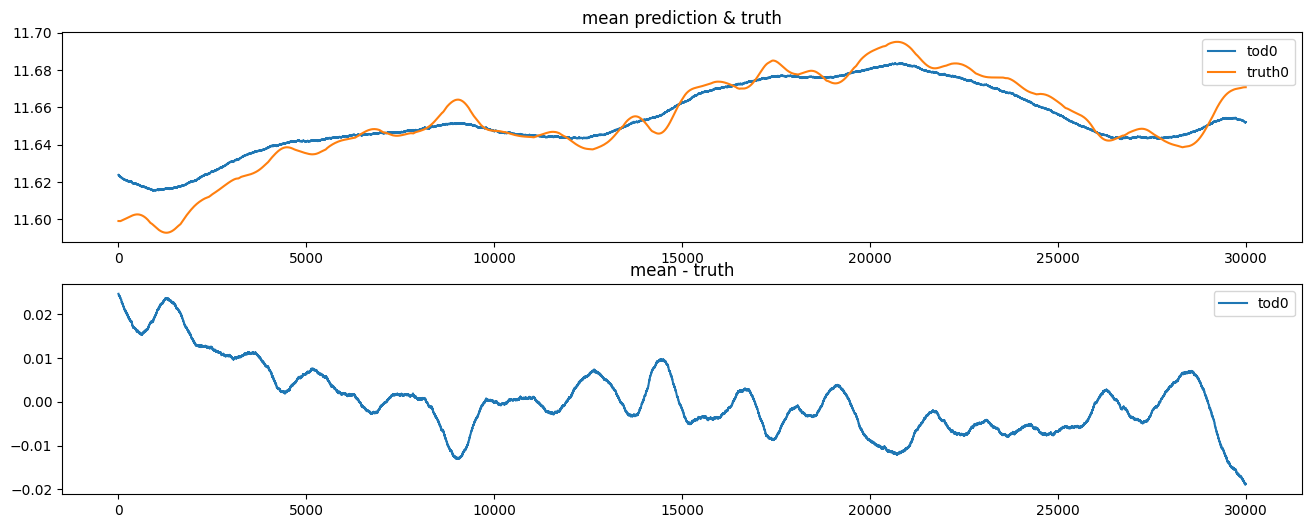

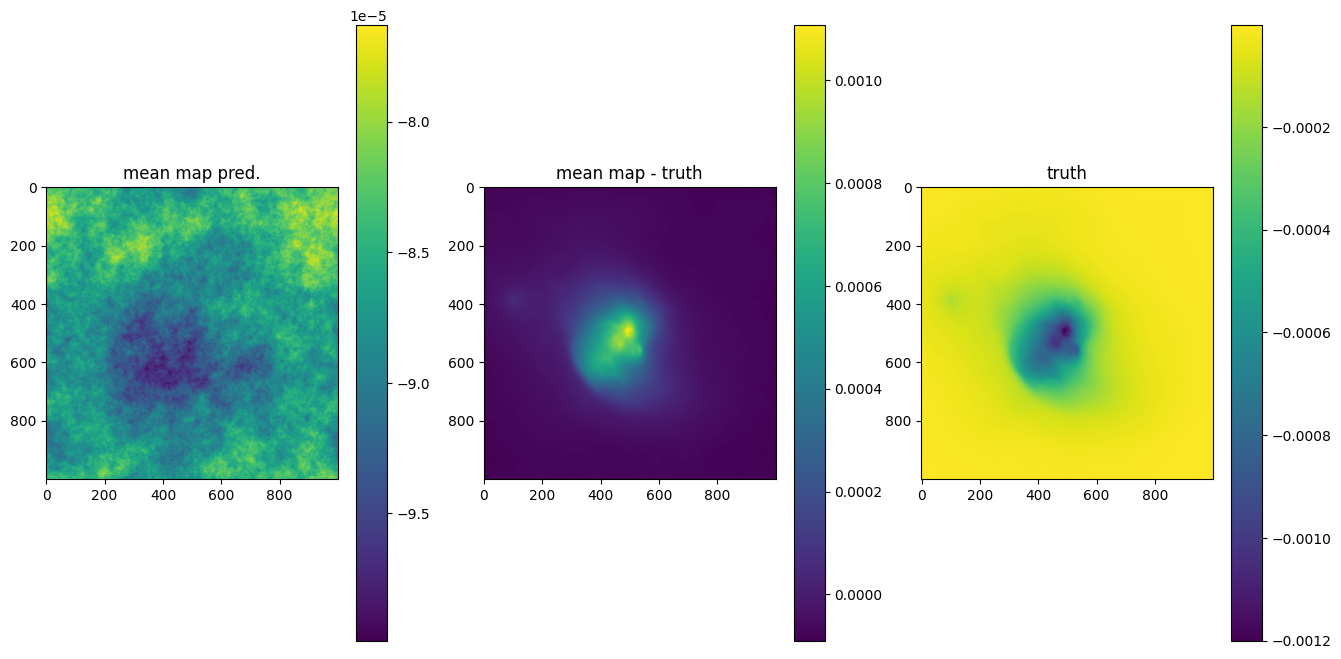

OPTIMIZE_KL: Starting 0002
SL: Iteration 0 ⛰:+1.1234e+17 Δ⛰:inf ➽:1.0320e+01
SL: Iteration 1 ⛰:+2.4863e+14 Δ⛰:1.1209e+17 ➽:1.0320e+01
SL: Iteration 2 ⛰:+1.6081e+14 Δ⛰:8.7820e+13 ➽:1.0320e+01
SL: Iteration 3 ⛰:+2.9938e+13 Δ⛰:1.3087e+14 ➽:1.0320e+01
SL: Iteration 4 ⛰:+1.8497e+13 Δ⛰:1.1442e+13 ➽:1.0320e+01
SL: Iteration 5 ⛰:+1.1946e+13 Δ⛰:6.5509e+12 ➽:1.0320e+01
SL: Iteration 6 ⛰:+1.1944e+13 Δ⛰:2.3163e+09 ➽:1.0320e+01
SL: Iteration 7 ⛰:+8.7350e+12 Δ⛰:3.2087e+12 ➽:1.0320e+01
SL: Iteration 8 ⛰:+7.5967e+12 Δ⛰:1.1383e+12 ➽:1.0320e+01
SL: Iteration 9 ⛰:+6.4150e+12 Δ⛰:1.1817e+12 ➽:1.0320e+01
SL: Iteration 10 ⛰:+6.4099e+12 Δ⛰:5.0585e+09 ➽:1.0320e+01
SL: Iteration 11 ⛰:+6.4096e+12 Δ⛰:3.6478e+08 ➽:1.0320e+01
SL: Iteration 12 ⛰:+5.3878e+12 Δ⛰:1.0217e+12 ➽:1.0320e+01
SL: Iteration 13 ⛰:+4.5379e+12 Δ⛰:8.4996e+11 ➽:1.0320e+01
SL: Iteration 14 ⛰:+3.9012e+12 Δ⛰:6.3668e+11 ➽:1.0320e+01
SL: Iteration 15 ⛰:+3.9007e+12 Δ⛰:5.0533e+08 ➽:1.0320e+01
SL: Iteration 16 ⛰:+3.5230e+12 Δ⛰:3.7773e+11 ➽:1.0320e+01
SL: 

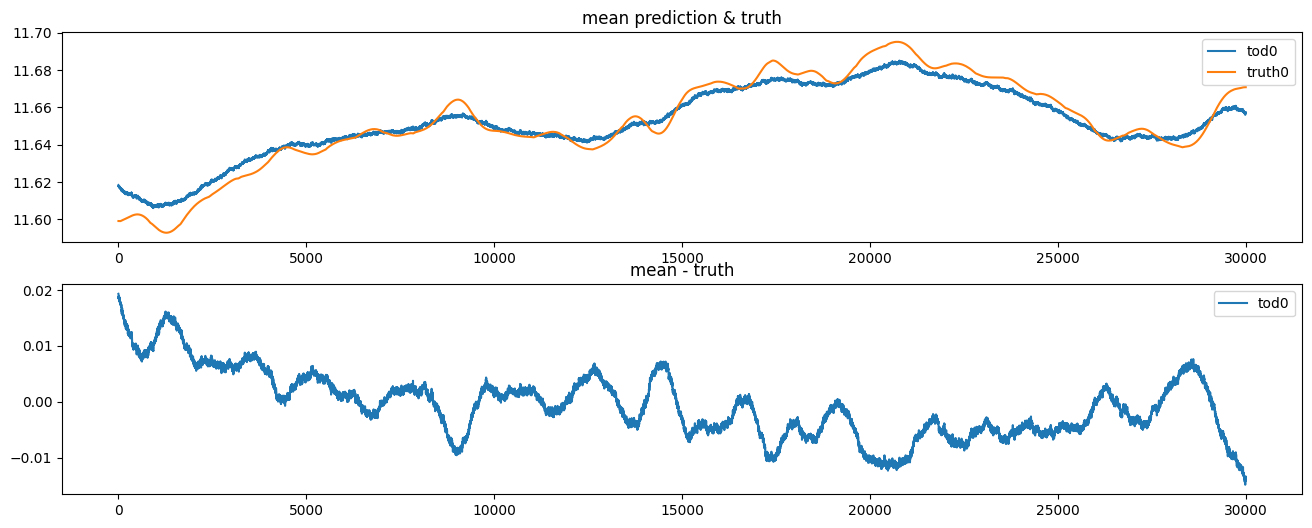

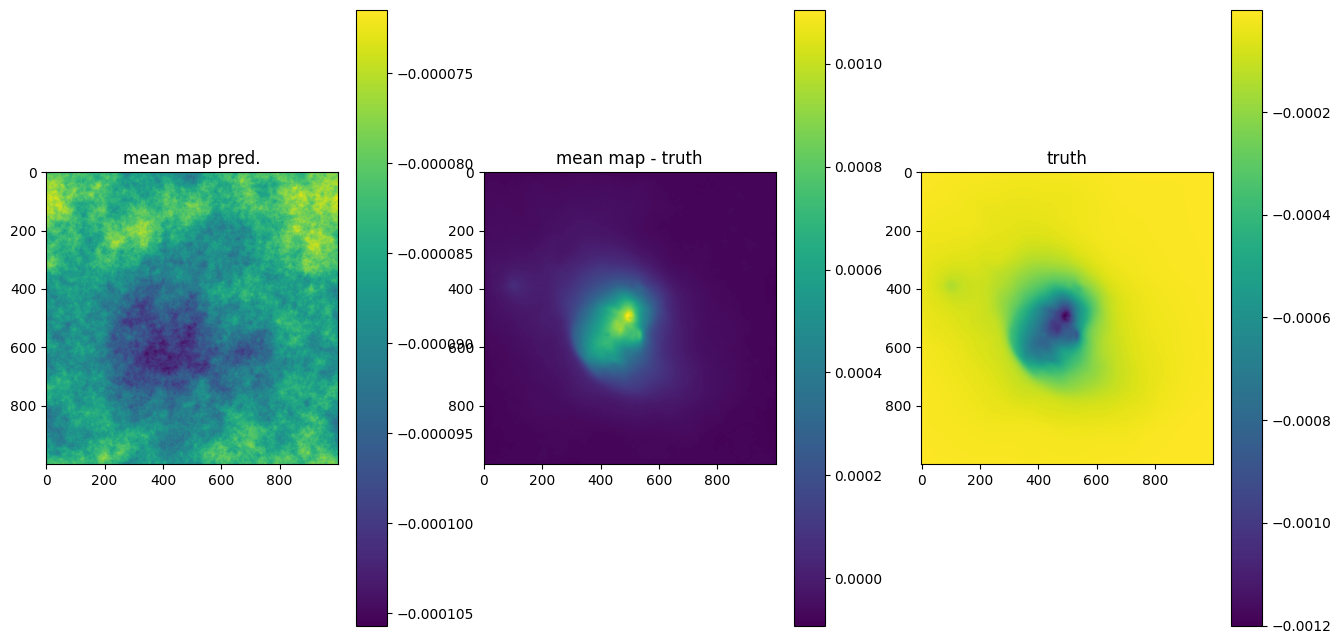

OPTIMIZE_KL: Starting 0003
SL: Iteration 0 ⛰:+2.5910e+16 Δ⛰:inf ➽:1.0320e+01
SL: Iteration 1 ⛰:+1.2997e+14 Δ⛰:2.5780e+16 ➽:1.0320e+01
SL: Iteration 2 ⛰:+9.7300e+13 Δ⛰:3.2667e+13 ➽:1.0320e+01
SL: Iteration 3 ⛰:+9.6515e+13 Δ⛰:7.8550e+11 ➽:1.0320e+01
SL: Iteration 4 ⛰:+6.1047e+13 Δ⛰:3.5468e+13 ➽:1.0320e+01
SL: Iteration 5 ⛰:+4.9518e+13 Δ⛰:1.1529e+13 ➽:1.0320e+01
SL: Iteration 6 ⛰:+4.9297e+13 Δ⛰:2.2086e+11 ➽:1.0320e+01
SL: Iteration 7 ⛰:+4.1589e+13 Δ⛰:7.7083e+12 ➽:1.0320e+01
SL: Iteration 8 ⛰:+3.4738e+13 Δ⛰:6.8507e+12 ➽:1.0320e+01
SL: Iteration 9 ⛰:+3.0448e+13 Δ⛰:4.2901e+12 ➽:1.0320e+01
SL: Iteration 10 ⛰:+2.8198e+13 Δ⛰:2.2504e+12 ➽:1.0320e+01
SL: Iteration 11 ⛰:+2.8189e+13 Δ⛰:9.0548e+09 ➽:1.0320e+01
SL: Iteration 12 ⛰:+2.8167e+13 Δ⛰:2.1947e+10 ➽:1.0320e+01
SL: Iteration 13 ⛰:+2.5347e+13 Δ⛰:2.8199e+12 ➽:1.0320e+01
SL: Iteration 14 ⛰:+2.5329e+13 Δ⛰:1.7721e+10 ➽:1.0320e+01
SL: Iteration 15 ⛰:+2.2605e+13 Δ⛰:2.7241e+12 ➽:1.0320e+01
SL: Iteration 16 ⛰:+2.2603e+13 Δ⛰:1.8165e+09 ➽:1.0320e+01
SL: 

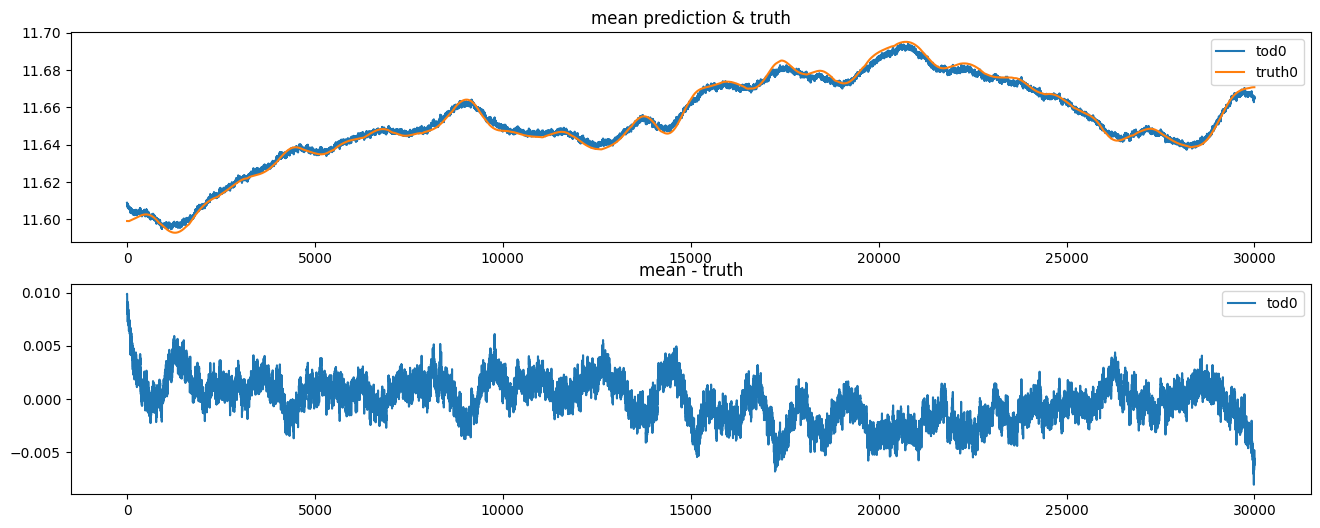

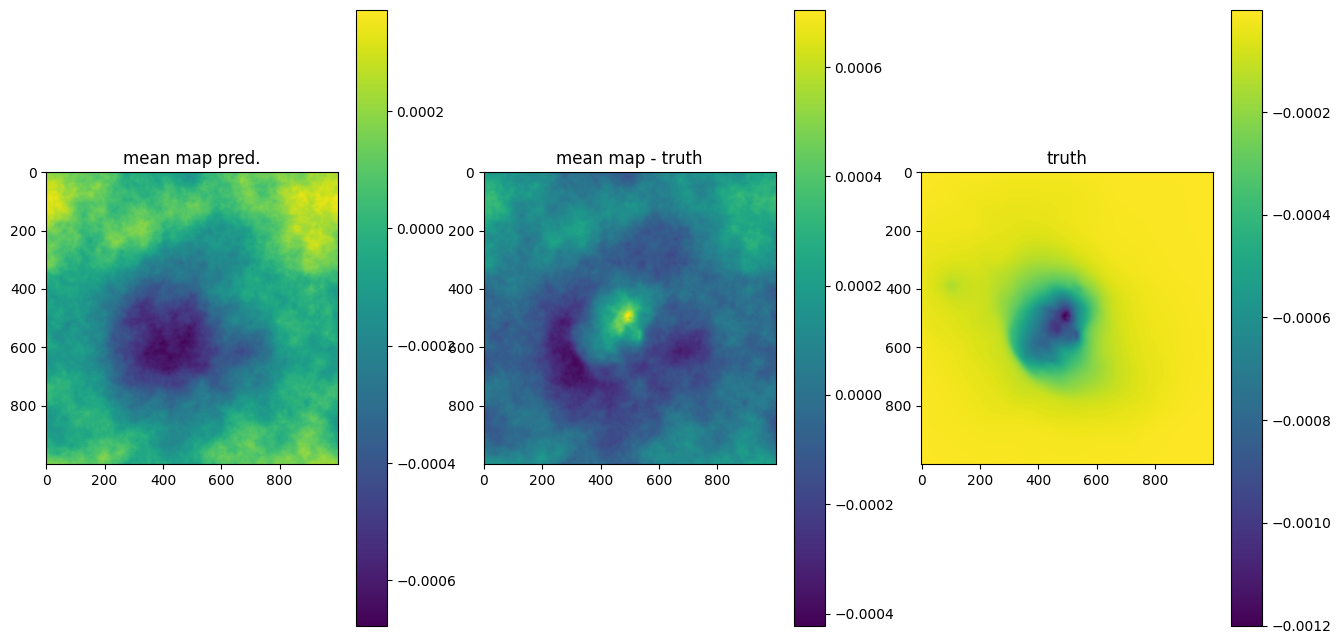

OPTIMIZE_KL: Starting 0004
SL: Iteration 0 ⛰:+1.0605e+17 Δ⛰:inf ➽:1.0320e+01
SL: Iteration 1 ⛰:+3.6237e+14 Δ⛰:1.0569e+17 ➽:1.0320e+01
SL: Iteration 2 ⛰:+2.9543e+14 Δ⛰:6.6943e+13 ➽:1.0320e+01
SL: Iteration 3 ⛰:+2.6480e+14 Δ⛰:3.0632e+13 ➽:1.0320e+01
SL: Iteration 4 ⛰:+2.3932e+14 Δ⛰:2.5478e+13 ➽:1.0320e+01
SL: Iteration 5 ⛰:+1.9268e+14 Δ⛰:4.6640e+13 ➽:1.0320e+01
SL: Iteration 6 ⛰:+1.9261e+14 Δ⛰:7.3716e+10 ➽:1.0320e+01
SL: Iteration 7 ⛰:+1.6515e+14 Δ⛰:2.7454e+13 ➽:1.0320e+01
SL: Iteration 8 ⛰:+1.3890e+14 Δ⛰:2.6251e+13 ➽:1.0320e+01
SL: Iteration 9 ⛰:+1.2448e+14 Δ⛰:1.4423e+13 ➽:1.0320e+01
SL: Iteration 10 ⛰:+1.0999e+14 Δ⛰:1.4491e+13 ➽:1.0320e+01
SL: Iteration 11 ⛰:+1.0999e+14 Δ⛰:1.3723e+09 ➽:1.0320e+01
SL: Iteration 12 ⛰:+1.0301e+14 Δ⛰:6.9776e+12 ➽:1.0320e+01
SL: Iteration 13 ⛰:+1.0076e+14 Δ⛰:2.2488e+12 ➽:1.0320e+01
SL: Iteration 14 ⛰:+9.1624e+13 Δ⛰:9.1366e+12 ➽:1.0320e+01
SL: Iteration 15 ⛰:+8.5083e+13 Δ⛰:6.5408e+12 ➽:1.0320e+01
SL: Iteration 16 ⛰:+8.5081e+13 Δ⛰:2.3984e+09 ➽:1.0320e+01
SL: 

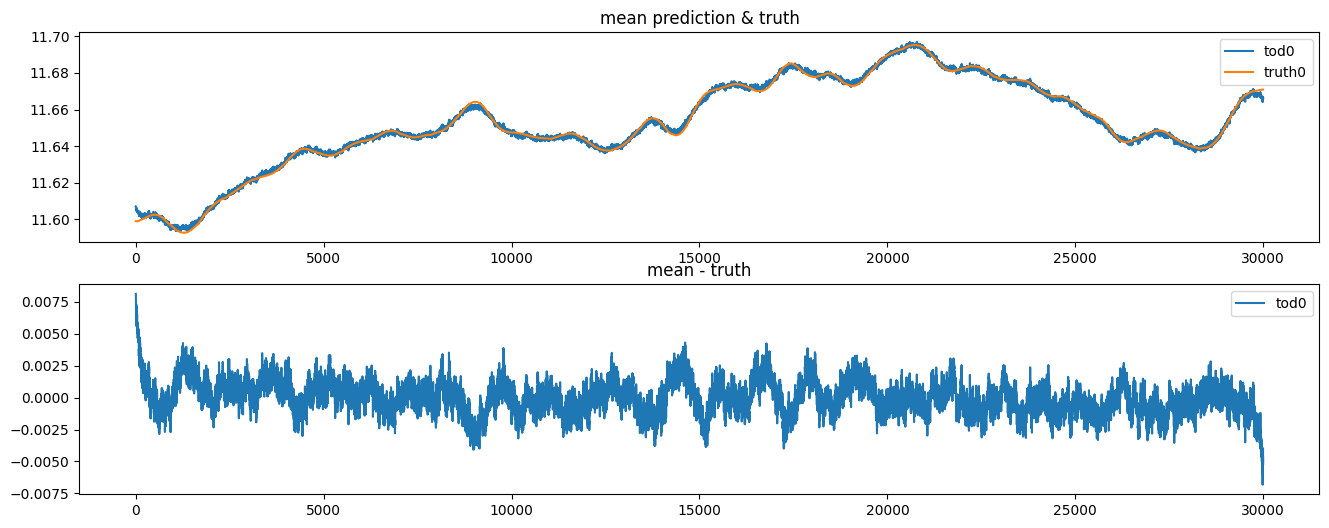

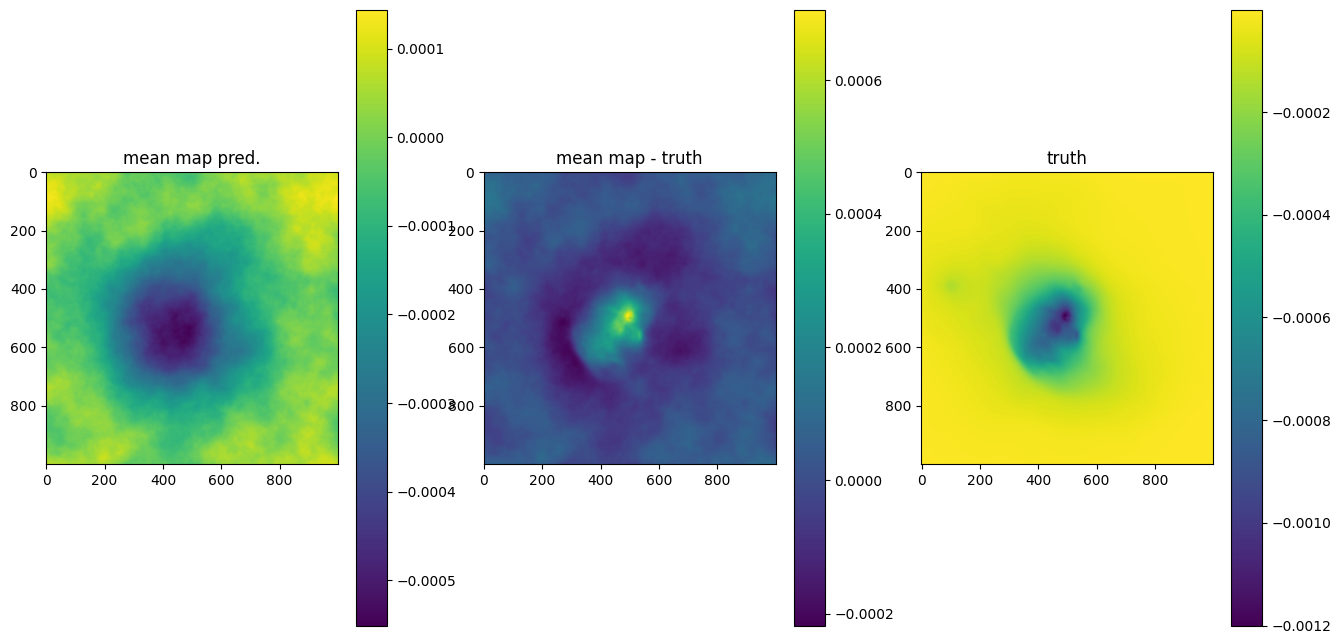

OPTIMIZE_KL: Starting 0005
SL: Iteration 0 ⛰:+1.3910e+16 Δ⛰:inf ➽:1.0320e+01
SL: Iteration 1 ⛰:+4.2413e+15 Δ⛰:9.6685e+15 ➽:1.0320e+01
SL: Iteration 2 ⛰:+2.5839e+14 Δ⛰:3.9829e+15 ➽:1.0320e+01
SL: Iteration 3 ⛰:+2.3692e+14 Δ⛰:2.1469e+13 ➽:1.0320e+01
SL: Iteration 4 ⛰:+2.2174e+14 Δ⛰:1.5173e+13 ➽:1.0320e+01
SL: Iteration 5 ⛰:+1.7085e+14 Δ⛰:5.0891e+13 ➽:1.0320e+01
SL: Iteration 6 ⛰:+1.6972e+14 Δ⛰:1.1377e+12 ➽:1.0320e+01
SL: Iteration 7 ⛰:+1.4184e+14 Δ⛰:2.7878e+13 ➽:1.0320e+01
SL: Iteration 8 ⛰:+1.1992e+14 Δ⛰:2.1921e+13 ➽:1.0320e+01
SL: Iteration 9 ⛰:+1.0196e+14 Δ⛰:1.7953e+13 ➽:1.0320e+01
SL: Iteration 10 ⛰:+8.9757e+13 Δ⛰:1.2207e+13 ➽:1.0320e+01
SL: Iteration 11 ⛰:+8.9755e+13 Δ⛰:1.8702e+09 ➽:1.0320e+01
SL: Iteration 12 ⛰:+8.8844e+13 Δ⛰:9.1172e+11 ➽:1.0320e+01
SL: Iteration 13 ⛰:+8.2740e+13 Δ⛰:6.1038e+12 ➽:1.0320e+01
SL: Iteration 14 ⛰:+7.6351e+13 Δ⛰:6.3885e+12 ➽:1.0320e+01
SL: Iteration 15 ⛰:+7.0366e+13 Δ⛰:5.9853e+12 ➽:1.0320e+01
SL: Iteration 16 ⛰:+7.0363e+13 Δ⛰:3.1012e+09 ➽:1.0320e+01
SL: 

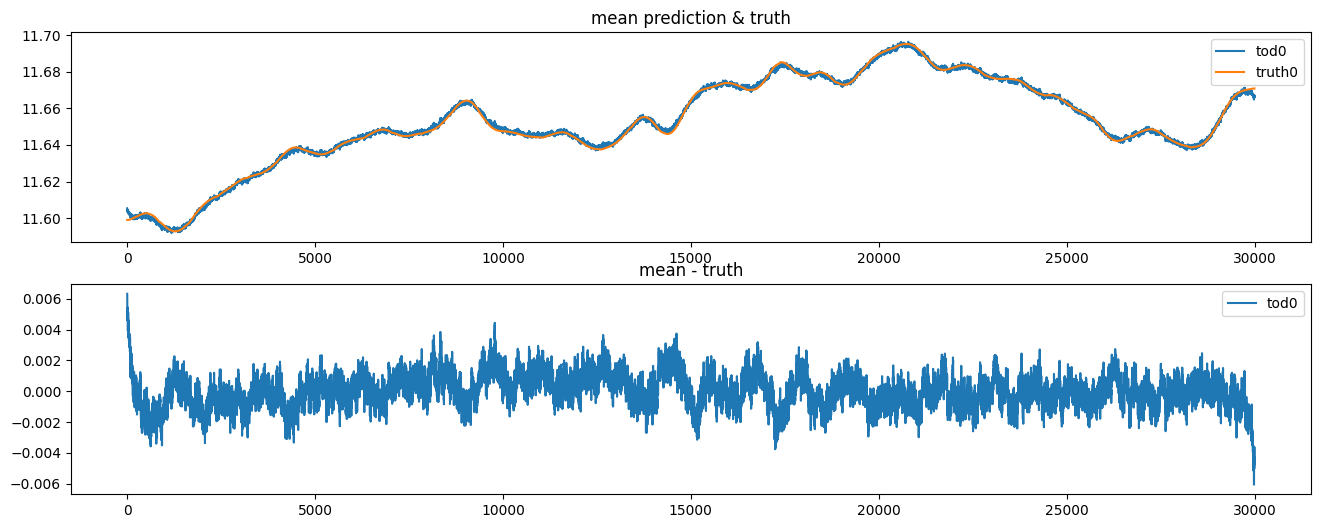

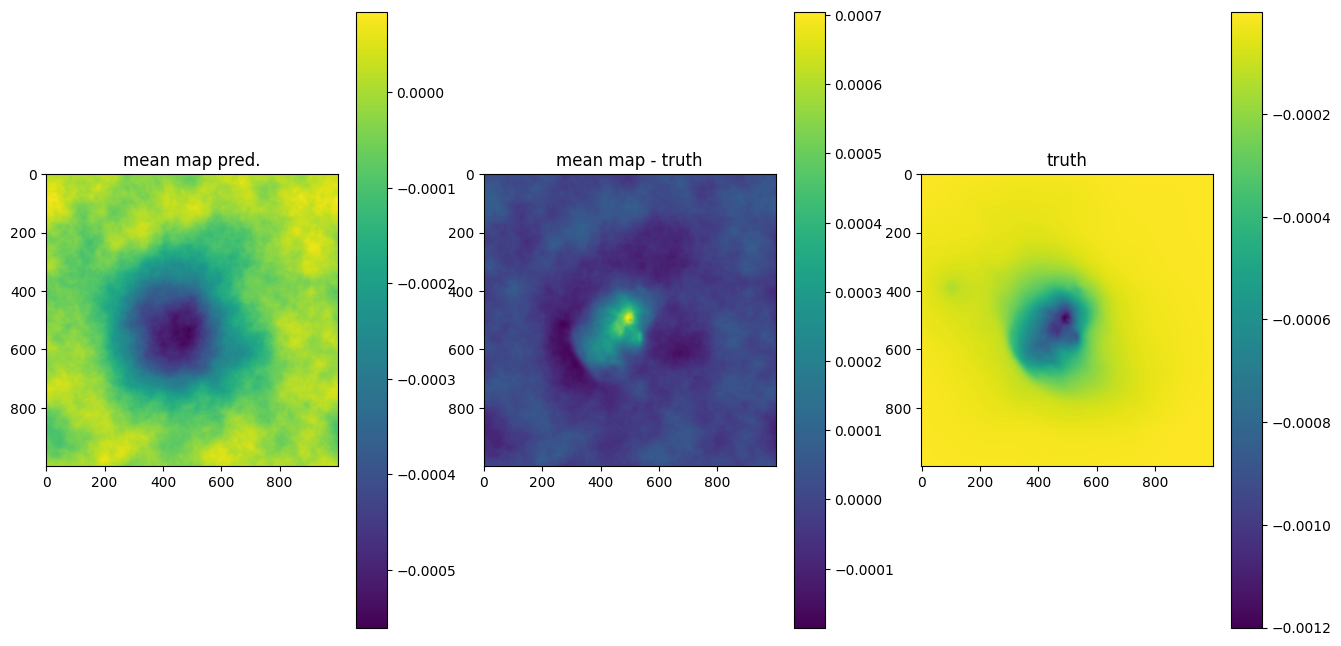

OPTIMIZE_KL: Starting 0006
SL: Iteration 0 ⛰:+3.9104e+17 Δ⛰:inf ➽:1.0320e+01
SL: Iteration 1 ⛰:+2.2518e+15 Δ⛰:3.8879e+17 ➽:1.0320e+01
SL: Iteration 2 ⛰:+2.9367e+14 Δ⛰:1.9581e+15 ➽:1.0320e+01
SL: Iteration 3 ⛰:+2.7066e+14 Δ⛰:2.3009e+13 ➽:1.0320e+01
SL: Iteration 4 ⛰:+1.9481e+14 Δ⛰:7.5853e+13 ➽:1.0320e+01
SL: Iteration 5 ⛰:+1.7577e+14 Δ⛰:1.9041e+13 ➽:1.0320e+01
SL: Iteration 6 ⛰:+1.7496e+14 Δ⛰:8.1042e+11 ➽:1.0320e+01
SL: Iteration 7 ⛰:+1.3686e+14 Δ⛰:3.8103e+13 ➽:1.0320e+01
SL: Iteration 8 ⛰:+1.1073e+14 Δ⛰:2.6130e+13 ➽:1.0320e+01
SL: Iteration 9 ⛰:+9.6015e+13 Δ⛰:1.4711e+13 ➽:1.0320e+01
SL: Iteration 10 ⛰:+7.8684e+13 Δ⛰:1.7332e+13 ➽:1.0320e+01
SL: Iteration 11 ⛰:+7.8639e+13 Δ⛰:4.4598e+10 ➽:1.0320e+01
SL: Iteration 12 ⛰:+7.8578e+13 Δ⛰:6.0637e+10 ➽:1.0320e+01
SL: Iteration 13 ⛰:+7.2030e+13 Δ⛰:6.5482e+12 ➽:1.0320e+01
SL: Iteration 14 ⛰:+6.7316e+13 Δ⛰:4.7140e+12 ➽:1.0320e+01
SL: Iteration 15 ⛰:+6.0871e+13 Δ⛰:6.4454e+12 ➽:1.0320e+01
SL: Iteration 16 ⛰:+6.0866e+13 Δ⛰:5.2378e+09 ➽:1.0320e+01
SL: 

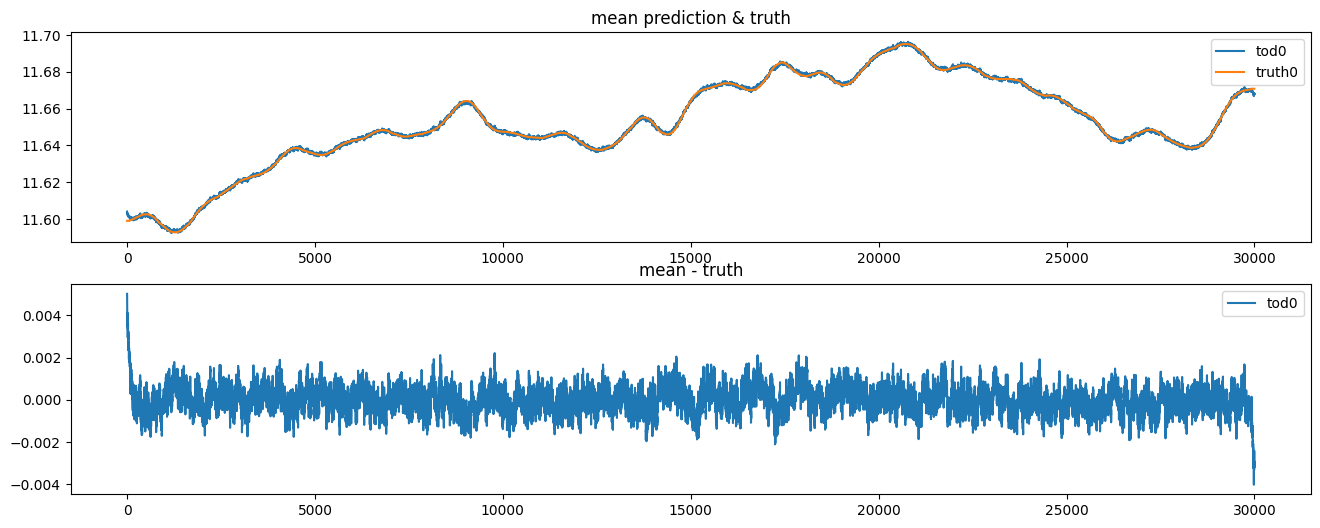

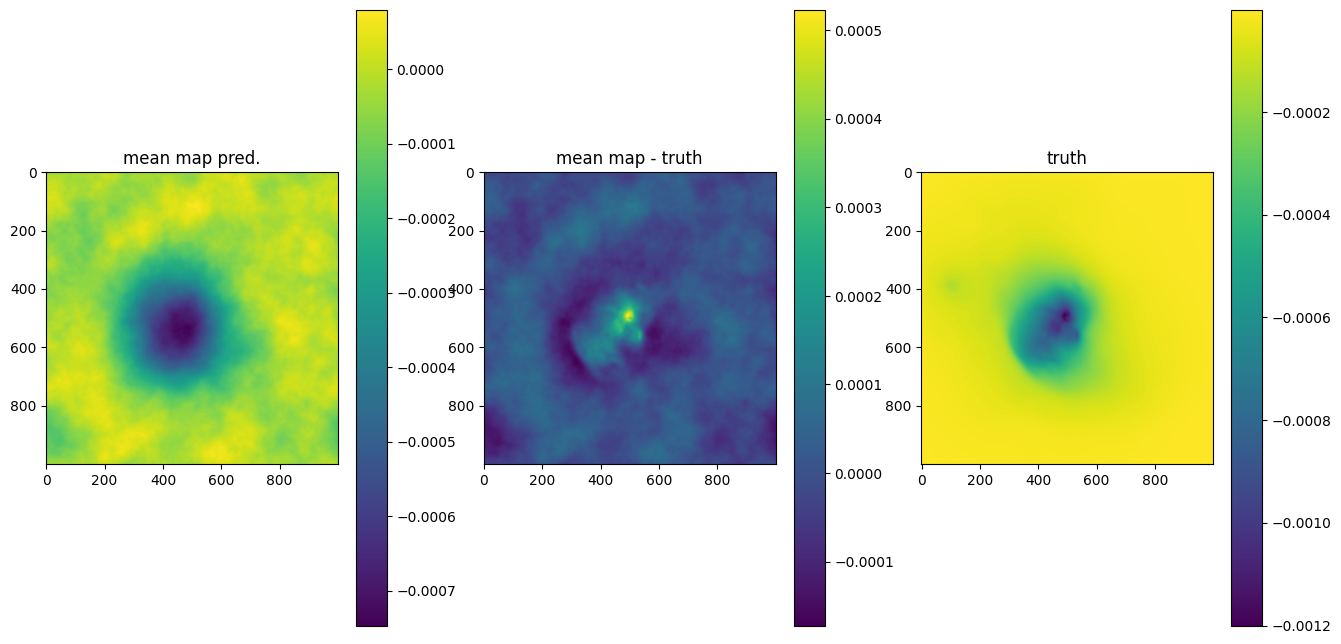

OPTIMIZE_KL: Starting 0007
SL: Iteration 0 ⛰:+4.4967e+16 Δ⛰:inf ➽:1.0320e+01
SL: Iteration 1 ⛰:+7.2282e+15 Δ⛰:3.7739e+16 ➽:1.0320e+01
SL: Iteration 2 ⛰:+8.2075e+14 Δ⛰:6.4075e+15 ➽:1.0320e+01
SL: Iteration 3 ⛰:+3.3305e+14 Δ⛰:4.8769e+14 ➽:1.0320e+01
SL: Iteration 4 ⛰:+2.3018e+14 Δ⛰:1.0287e+14 ➽:1.0320e+01
SL: Iteration 5 ⛰:+1.2306e+14 Δ⛰:1.0712e+14 ➽:1.0320e+01
SL: Iteration 6 ⛰:+1.1668e+14 Δ⛰:6.3873e+12 ➽:1.0320e+01
SL: Iteration 7 ⛰:+9.8705e+13 Δ⛰:1.7970e+13 ➽:1.0320e+01
SL: Iteration 8 ⛰:+7.9438e+13 Δ⛰:1.9267e+13 ➽:1.0320e+01
SL: Iteration 9 ⛰:+6.7358e+13 Δ⛰:1.2080e+13 ➽:1.0320e+01
SL: Iteration 10 ⛰:+6.1614e+13 Δ⛰:5.7440e+12 ➽:1.0320e+01
SL: Iteration 11 ⛰:+6.1594e+13 Δ⛰:1.9851e+10 ➽:1.0320e+01
SL: Iteration 12 ⛰:+6.1466e+13 Δ⛰:1.2825e+11 ➽:1.0320e+01
SL: Iteration 13 ⛰:+5.2846e+13 Δ⛰:8.6199e+12 ➽:1.0320e+01
SL: Iteration 14 ⛰:+4.5420e+13 Δ⛰:7.4263e+12 ➽:1.0320e+01
SL: Iteration 15 ⛰:+4.2970e+13 Δ⛰:2.4491e+12 ➽:1.0320e+01
SL: Iteration 16 ⛰:+4.2948e+13 Δ⛰:2.2649e+10 ➽:1.0320e+01
SL: 

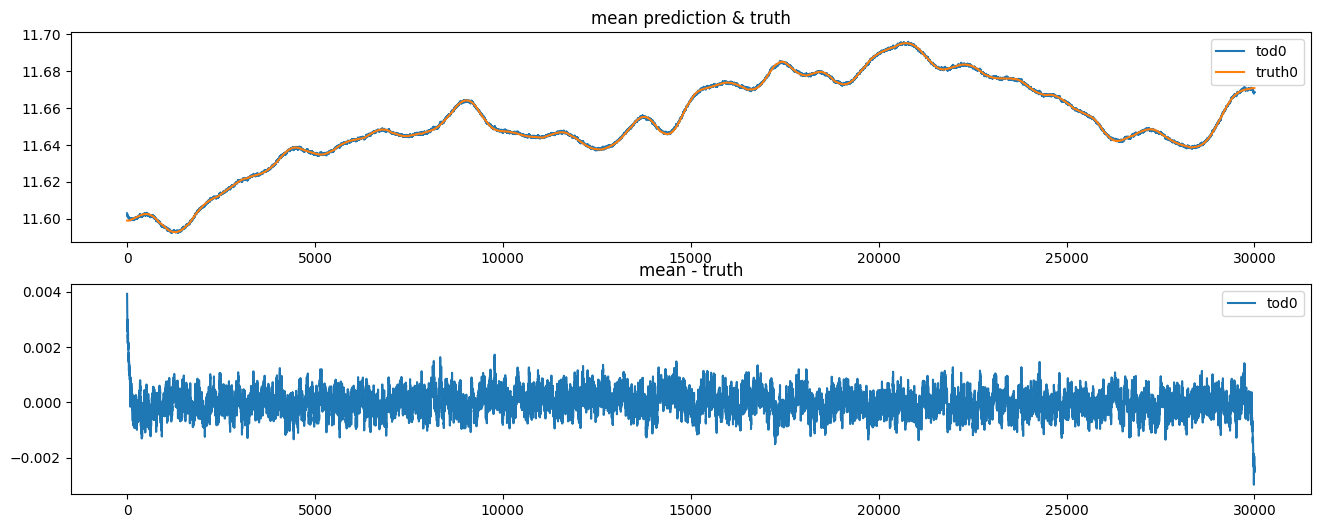

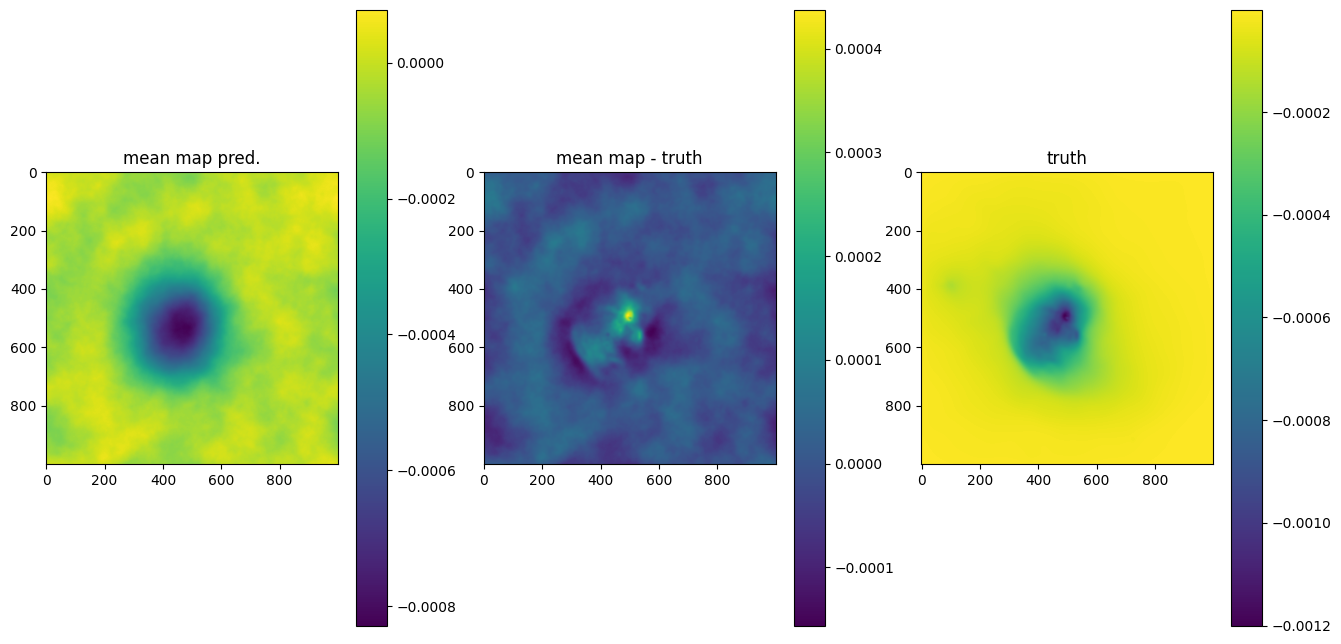

OPTIMIZE_KL: Starting 0008
SL: Iteration 0 ⛰:+2.2382e+16 Δ⛰:inf ➽:1.0320e+01
SL: Iteration 1 ⛰:+1.2618e+15 Δ⛰:2.1120e+16 ➽:1.0320e+01
SL: Iteration 2 ⛰:+6.1319e+14 Δ⛰:6.4864e+14 ➽:1.0320e+01
SL: Iteration 3 ⛰:+4.1212e+14 Δ⛰:2.0107e+14 ➽:1.0320e+01
SL: Iteration 4 ⛰:+2.5939e+14 Δ⛰:1.5273e+14 ➽:1.0320e+01
SL: Iteration 5 ⛰:+1.3641e+14 Δ⛰:1.2298e+14 ➽:1.0320e+01
SL: Iteration 6 ⛰:+8.8419e+13 Δ⛰:4.7994e+13 ➽:1.0320e+01
SL: Iteration 7 ⛰:+8.7099e+13 Δ⛰:1.3199e+12 ➽:1.0320e+01
SL: Iteration 8 ⛰:+6.7495e+13 Δ⛰:1.9604e+13 ➽:1.0320e+01
SL: Iteration 9 ⛰:+5.3263e+13 Δ⛰:1.4232e+13 ➽:1.0320e+01
SL: Iteration 10 ⛰:+4.5627e+13 Δ⛰:7.6363e+12 ➽:1.0320e+01
SL: Iteration 11 ⛰:+4.5566e+13 Δ⛰:6.0513e+10 ➽:1.0320e+01
SL: Iteration 12 ⛰:+4.5501e+13 Δ⛰:6.4765e+10 ➽:1.0320e+01
SL: Iteration 13 ⛰:+4.0123e+13 Δ⛰:5.3779e+12 ➽:1.0320e+01
SL: Iteration 14 ⛰:+3.5687e+13 Δ⛰:4.4360e+12 ➽:1.0320e+01
SL: Iteration 15 ⛰:+3.1919e+13 Δ⛰:3.7682e+12 ➽:1.0320e+01
SL: Iteration 16 ⛰:+3.1716e+13 Δ⛰:2.0277e+11 ➽:1.0320e+01
SL: 

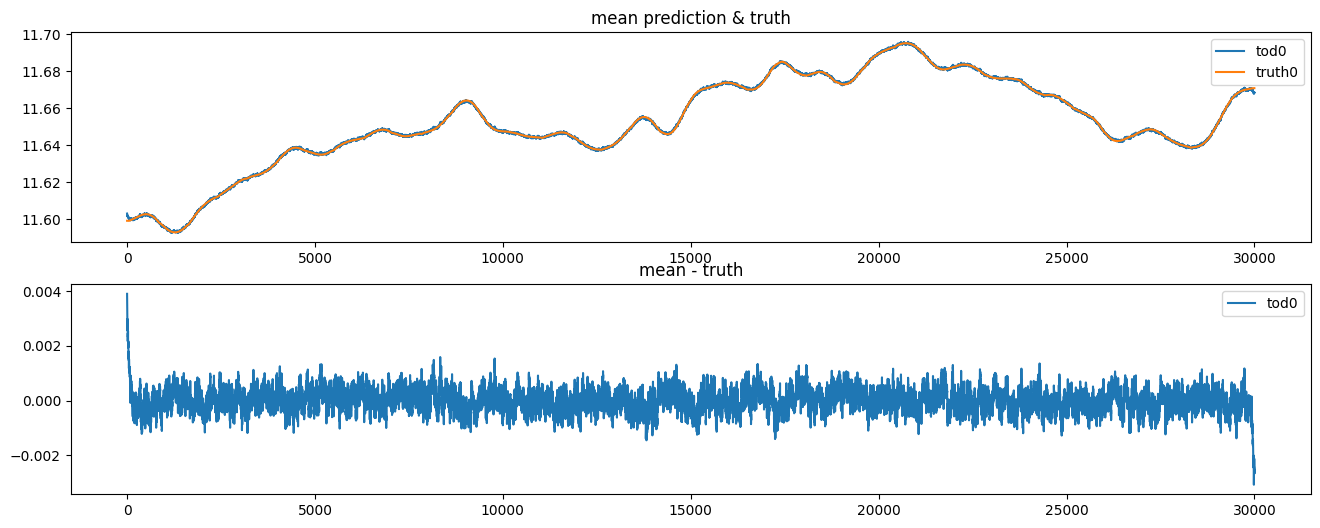

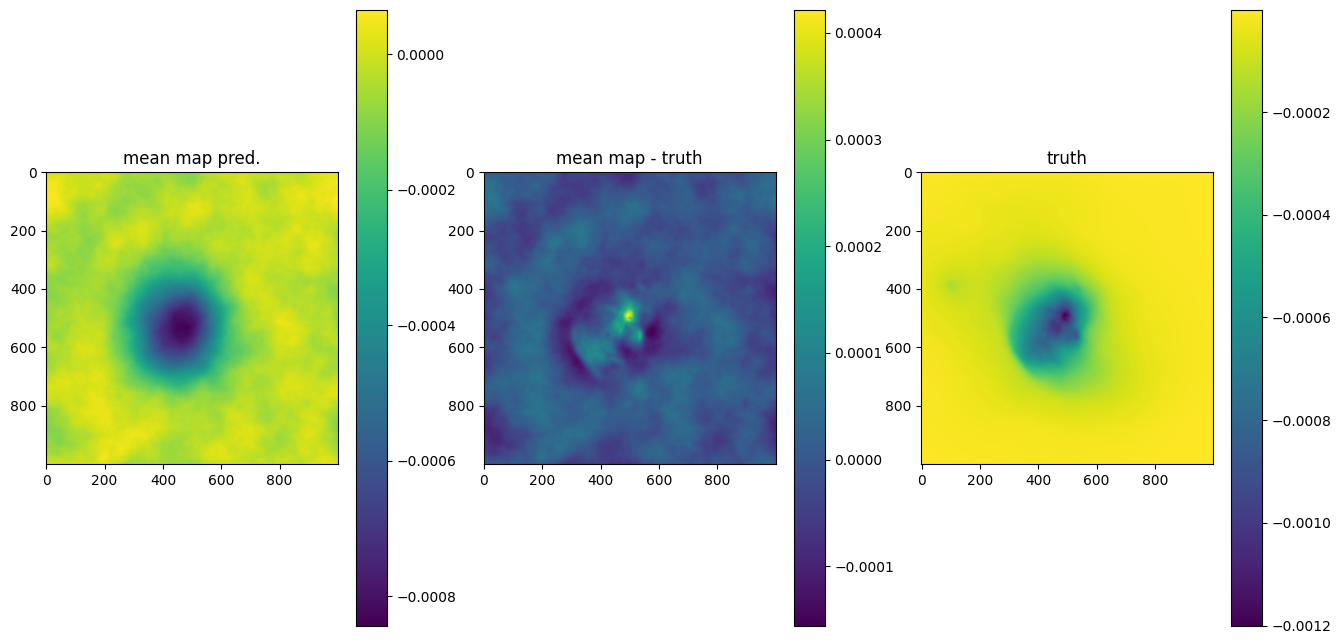

OPTIMIZE_KL: Starting 0009
SL: Iteration 0 ⛰:+1.0322e+17 Δ⛰:inf ➽:1.0320e+01
SL: Iteration 1 ⛰:+8.8104e+14 Δ⛰:1.0234e+17 ➽:1.0320e+01
SL: Iteration 2 ⛰:+5.6711e+14 Δ⛰:3.1393e+14 ➽:1.0320e+01
SL: Iteration 3 ⛰:+2.0063e+14 Δ⛰:3.6648e+14 ➽:1.0320e+01
SL: Iteration 4 ⛰:+1.4462e+14 Δ⛰:5.6007e+13 ➽:1.0320e+01
SL: Iteration 5 ⛰:+1.0967e+14 Δ⛰:3.4957e+13 ➽:1.0320e+01
SL: Iteration 6 ⛰:+9.2135e+13 Δ⛰:1.7531e+13 ➽:1.0320e+01
SL: Iteration 7 ⛰:+8.3934e+13 Δ⛰:8.2011e+12 ➽:1.0320e+01
SL: Iteration 8 ⛰:+5.9152e+13 Δ⛰:2.4782e+13 ➽:1.0320e+01
SL: Iteration 9 ⛰:+4.7248e+13 Δ⛰:1.1904e+13 ➽:1.0320e+01
SL: Iteration 10 ⛰:+4.0511e+13 Δ⛰:6.7371e+12 ➽:1.0320e+01
SL: Iteration 11 ⛰:+4.0407e+13 Δ⛰:1.0347e+11 ➽:1.0320e+01
SL: Iteration 12 ⛰:+4.0402e+13 Δ⛰:5.6219e+09 ➽:1.0320e+01
SL: Iteration 13 ⛰:+3.4273e+13 Δ⛰:6.1287e+12 ➽:1.0320e+01
SL: Iteration 14 ⛰:+3.0036e+13 Δ⛰:4.2365e+12 ➽:1.0320e+01
SL: Iteration 15 ⛰:+2.7826e+13 Δ⛰:2.2101e+12 ➽:1.0320e+01
SL: Iteration 16 ⛰:+2.7725e+13 Δ⛰:1.0083e+11 ➽:1.0320e+01
SL: 

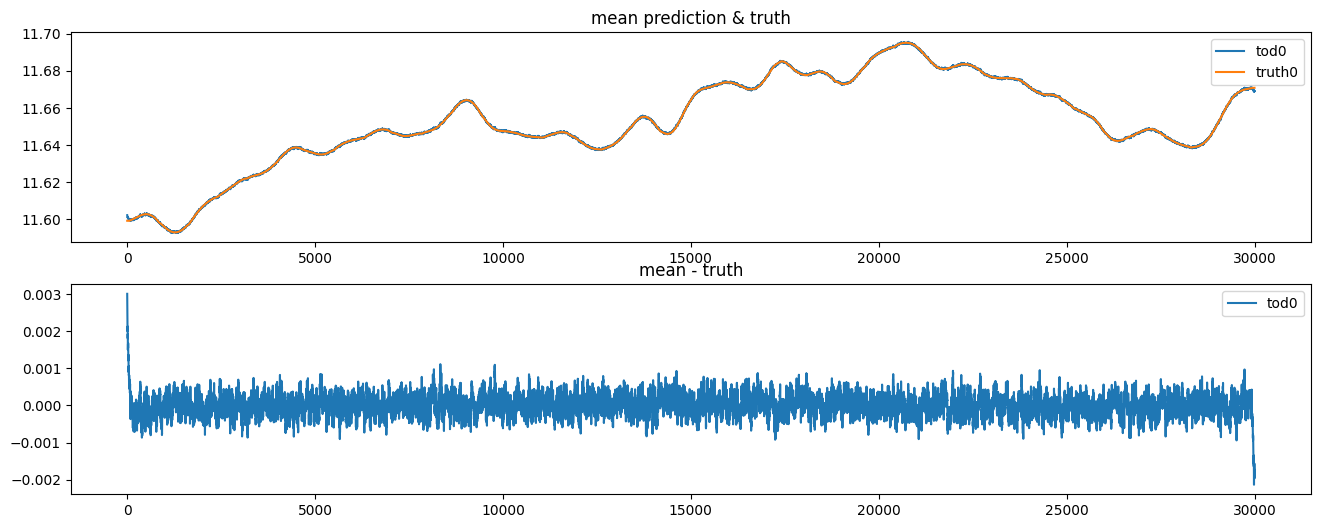

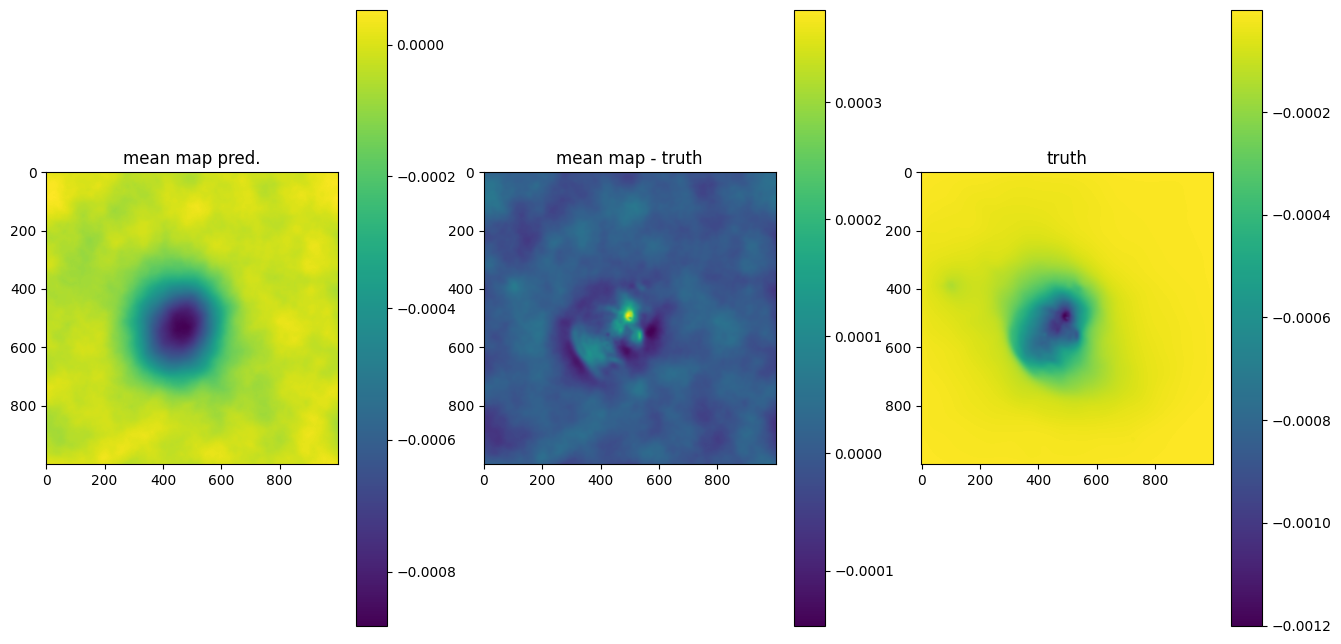

OPTIMIZE_KL: Starting 0010
SL: Iteration 0 ⛰:+1.6912e+16 Δ⛰:inf ➽:1.0320e+01
SL: Iteration 1 ⛰:+1.8786e+15 Δ⛰:1.5034e+16 ➽:1.0320e+01
SL: Iteration 2 ⛰:+6.4288e+14 Δ⛰:1.2357e+15 ➽:1.0320e+01
SL: Iteration 3 ⛰:+3.4311e+14 Δ⛰:2.9977e+14 ➽:1.0320e+01
SL: Iteration 4 ⛰:+2.7702e+14 Δ⛰:6.6086e+13 ➽:1.0320e+01
SL: Iteration 5 ⛰:+1.1596e+14 Δ⛰:1.6106e+14 ➽:1.0320e+01
SL: Iteration 6 ⛰:+8.9214e+13 Δ⛰:2.6747e+13 ➽:1.0320e+01
SL: Iteration 7 ⛰:+8.9066e+13 Δ⛰:1.4810e+11 ➽:1.0320e+01
SL: Iteration 8 ⛰:+6.0937e+13 Δ⛰:2.8129e+13 ➽:1.0320e+01
SL: Iteration 9 ⛰:+3.9983e+13 Δ⛰:2.0954e+13 ➽:1.0320e+01
SL: Iteration 10 ⛰:+3.5724e+13 Δ⛰:4.2599e+12 ➽:1.0320e+01
SL: Iteration 11 ⛰:+3.5686e+13 Δ⛰:3.7570e+10 ➽:1.0320e+01
SL: Iteration 12 ⛰:+3.5661e+13 Δ⛰:2.5034e+10 ➽:1.0320e+01
SL: Iteration 13 ⛰:+2.9315e+13 Δ⛰:6.3459e+12 ➽:1.0320e+01
SL: Iteration 14 ⛰:+2.5416e+13 Δ⛰:3.8992e+12 ➽:1.0320e+01
SL: Iteration 15 ⛰:+2.2760e+13 Δ⛰:2.6554e+12 ➽:1.0320e+01
SL: Iteration 16 ⛰:+2.1883e+13 Δ⛰:8.7709e+11 ➽:1.0320e+01
SL: 

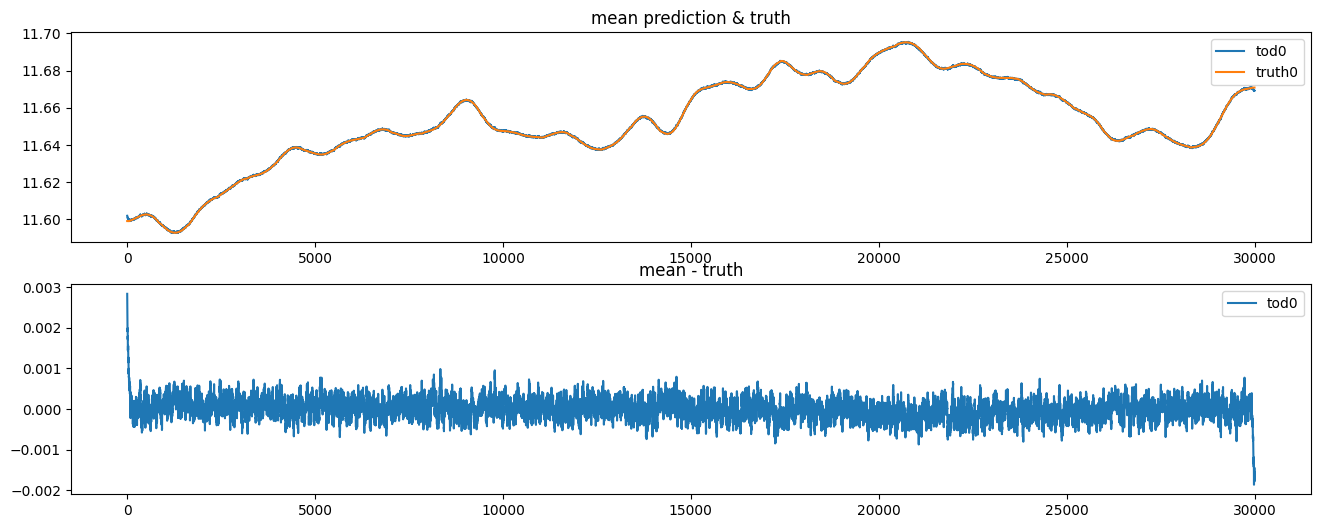

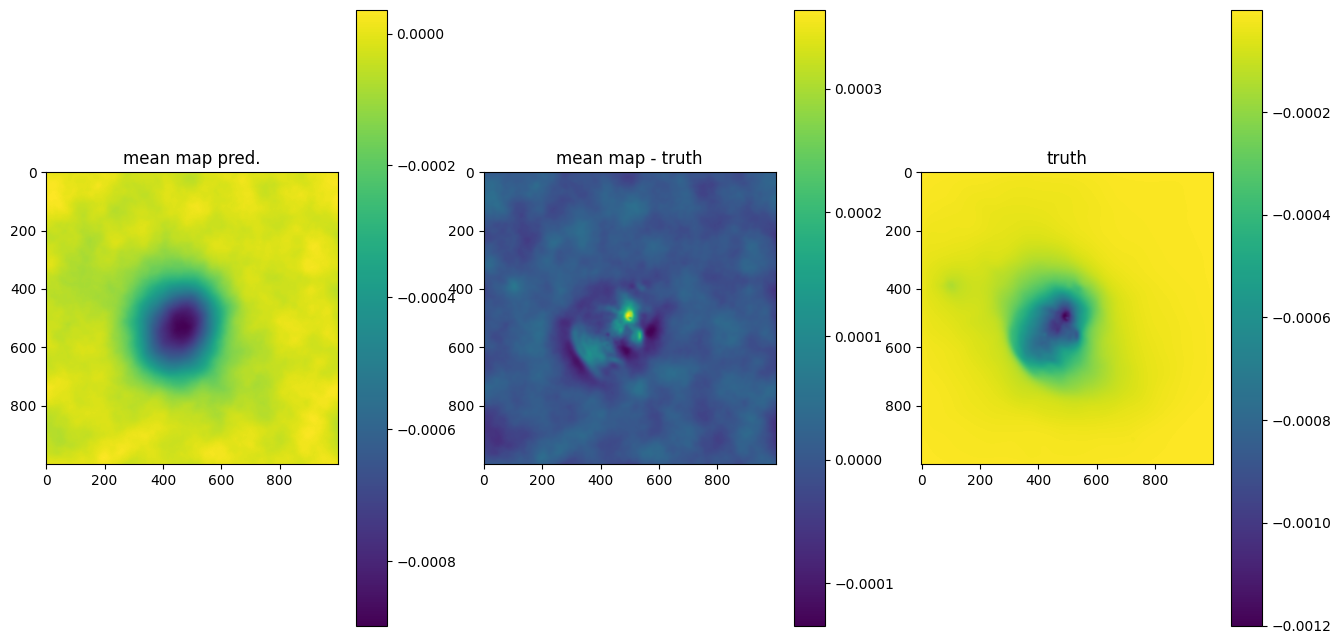

In [49]:
n_it = 10
# n_it = 20
# delta = 1e-4 # default
# delta = 1e-8 # map
# tod
# if noiselevel == 0.0: delta = 1e-6
if noiselevel == 0.0: delta = 1e-4
# if noiselevel == 0.0: delta = 1e-11
elif noiselevel == 0.1: delta = 1e-10
elif noiselevel == 0.5: delta = 1e-10
elif noiselevel == 1.0: delta = 1e-4
n_samples = 4 # no samples -> maximum aposteriory posterior

key, k_i, k_o = random.split(key, 3)

# callback fn for plotting during optimisation:
def callback(samples, opt_state):
    mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

    fig_tods, axes_tods = plt.subplots(2, 1, figsize=(16, 6))

    # for i in range(0, mean.shape[0], mean.shape[0]//10):
    for i in range(n):
        axes_tods[0].plot(np.arange(0, mean.shape[1]), mean[i], label=f"tod{i}")
        axes_tods[0].plot(truth[i], label=f"truth{i}")
        axes_tods[1].plot(np.arange(0, mean.shape[1]), mean[i] - truth[i], label=f"tod{i}")

    axes_tods[0].title.set_text('mean prediction & truth')
    axes_tods[0].legend()
    axes_tods[1].title.set_text('mean - truth')
    axes_tods[1].legend()

    fig_map, axes_map = plt.subplots(1, 3, figsize=(16, 8))

    mean_map, _ = jft.mean_and_std(tuple(gp_map(s) for s in samples))

    im0 = axes_map[0].imshow(mean_map)
    axes_map[0].title.set_text('mean map pred.')
    fig_map.colorbar(im0)

    im1 = axes_map[1].imshow(mean_map - mapdata_truth[0])
    axes_map[1].title.set_text('mean map - truth')
    fig_map.colorbar(im1)

    im2 = axes_map[2].imshow(mapdata_truth[0])
    axes_map[2].title.set_text('truth')
    fig_map.colorbar(im2)

    plt.show()
    

samples, state = jft.optimize_kl(
    lh, # likelihood
    jft.Vector(lh.init(k_i)), # initial position in model space (initialisation)
    n_total_iterations=n_it, # no of optimisation steps (global)
    n_samples=n_samples, # draw samples
    key=k_o, # random jax init
    draw_linear_kwargs=dict( # sampling parameters
        cg_name="SL",
        cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=60),
        # cg_kwargs=dict(absdelta=delta * jft.size(lh.domain) / 10.0, maxiter=10),
    ),
    nonlinearly_update_kwargs=dict( # map from multivariate gaussian to more compl. distribution (coordinate transformations)
        minimize_kwargs=dict(
            name="SN",
            xtol=delta,
            cg_kwargs=dict(name=None),
            maxiter=5,
        )
    ),
    kl_kwargs=dict( # shift transformed multivar gauss to best match true posterior
        minimize_kwargs=dict(
            name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=60
            # name="M", xtol=delta, cg_kwargs=dict(name=None), maxiter=10
        )
    ),
    # sample_mode="nonlinear_resample", # how steps are combined (samples + nonlin + KL)
    sample_mode = lambda x: "nonlinear_resample" if x >= 1 else "linear_resample",
    callback=callback,
)

In [50]:
printfitresults()

Fit Results (res, init, std)

TODs:
	fluctuations: 0.0011787722462272782, 0.005, 0.005
	loglogvarslope: -1.5710123311973443, -3, 0.5
	zeromode std (LogNormal): 0.00021612687198621584, 0.0005, 0.001
map:
	fluctuations: 0.00011588674254970842, 1e-06, 1e-06
	loglogvarslope: -4.472424055957664, -2.5, 0.5
	zeromode std (LogNormal): 3.492539231519586e-09, 1e-08, 1e-07


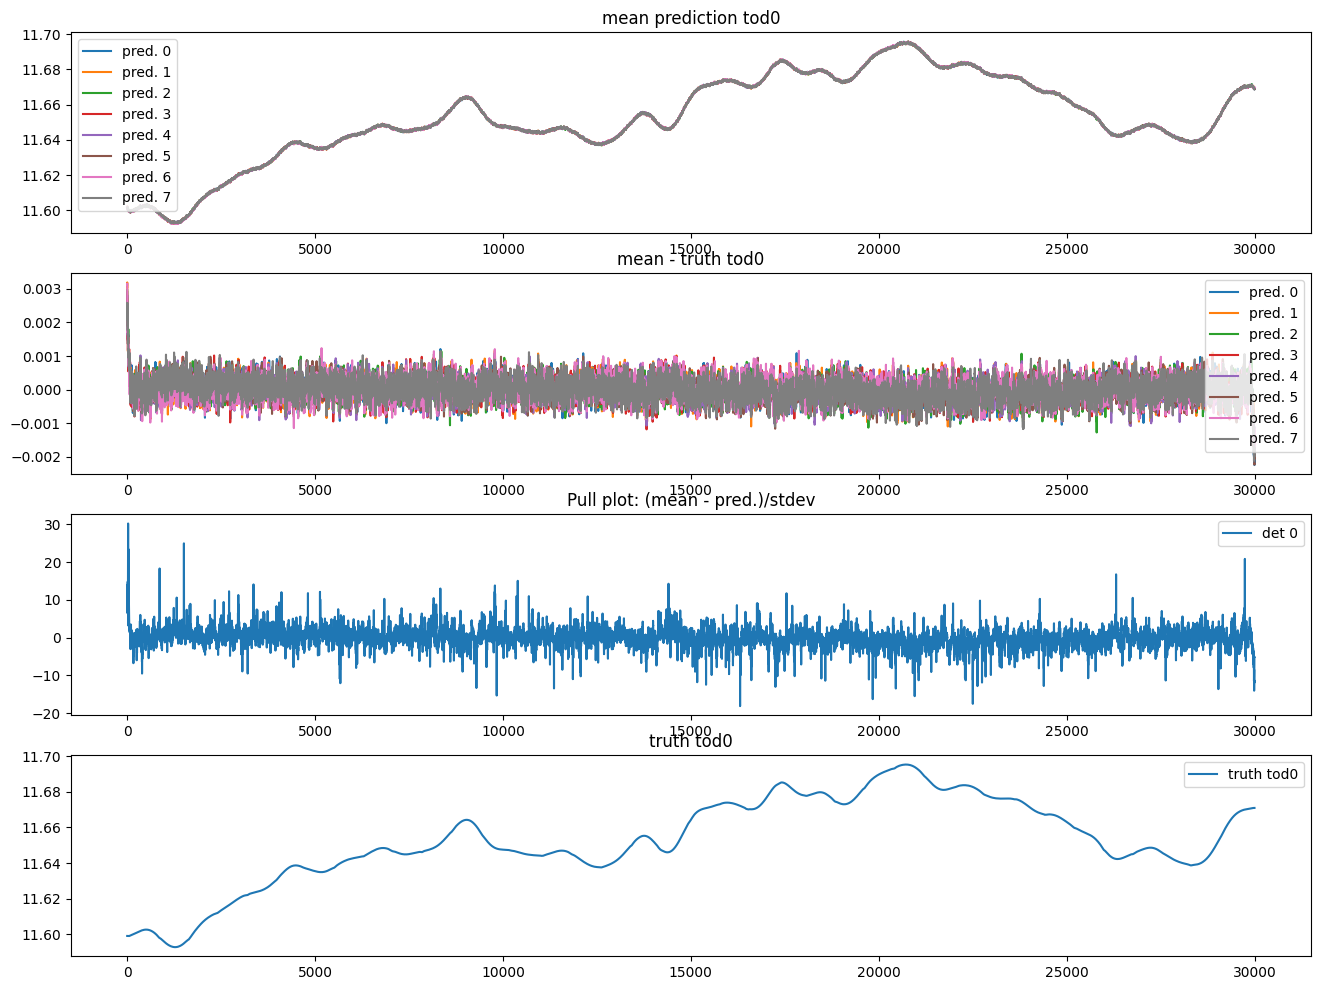

In [53]:
mean, std = jft.mean_and_std(tuple(signal_response_tod(s) for s in samples))

fig, axes = plt.subplots(4, 1, figsize=(16, 12))
i = 0
j = 0
# for i in range(mean.shape[0]):
for s in samples:
    pred = signal_response_tod(s)
    
    im0 = axes[0].plot(np.arange(0, pred.shape[1]), pred[i], label=f"pred. {j}")
    im1 = axes[1].plot(np.arange(0, pred.shape[1]), pred[i] - truth[i], label=f"pred. {j}")
    j += 1

im2 = axes[2].plot(np.arange(0, pred.shape[1]), (mean[i] - truth[i])/std[i], label=f"det {i}")
im3 = axes[3].plot(truth[i], label=f"truth tod{i}")
axes[0].title.set_text(f"mean prediction tod{i}")
axes[0].legend()
axes[1].title.set_text(f"mean - truth tod{i}")
axes[1].legend()
axes[2].title.set_text(f"Pull plot: (mean - pred.)/stdev")
axes[2].legend()
axes[3].title.set_text(f"truth tod{i}")
axes[3].legend()

plt.show()